# Analysis on trading data


## Description of the Data:

3 CSV files. 
1 containing all the trades Ryan made in the last 1.5 years. And various data associated with the stock and trade.
2 containing stock specific data, market cap, sector etc.

## Data Analysis goals:

Ultimate goal is a method to compute the stock variance for the current day or in real time if possible. Use this to suggest a stop loss that will not be triggered by noise. When a news event occurs, Ryan will predict a price direction and what a likely gain amount could be. But he needs to understand where to place his stop to take advantage of the move. 

The hypothethis is that if you can place a stop and have a high confidance interval to be outside of the noise, if the stop gets triggered, its an indicator that the move prediction was wrong. Otherwise you are well placed to take advantage of the new direction.

Another goal is to use XGBoost to predict losses for all the winning trades, and wins for all the losing trades. In order to guess at where Ryan would have put his stop for wins, or potential gains from losses. Unclear how accurate this would be.

Additional goals are:
+ Find metric and/or correlations to predict noise of a stock
+ Find a formula to predict the likelyhood of getting stopped out based on certain metrics from a given stock
+ Find correlations that cause Ryan to make a winning trade
+ Display general trading stats.

Split dataset:
+ long/short
+ win/loss
+ Useful trades (Specific slice of the dataset taking out sectors he no longer trades)
+ Swing trades (Swing trading is trader jargon for a longer term trade)

Other possible metrics:
The velocity of the stock (how often it changes hands). This would be something like float - institutional ownership / volume.
How much 1 share sold/bought effects the price.

**Chimera stock data:**
* data of all ticks, quotes, offers, for all stocks over the last 4 years.
* Condense into 1 second candles.
* Sample tick data over 1 year.
* Uncompress any data over 1 year.

Extract all moves over 10% (for example) within 2 weeks. Sample slices with minimum gain of 5%, get difference between point and min over remaining period. This shows the highest minimum price point to put a stop that would not be triggered by that move. Do this for up and down trends. After training, return confidance interval of being outside random noise factor.

In [700]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm as cm
%matplotlib inline
import json
import datetime
from dateutil import parser
from scipy.stats import linregress
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost import XGBClassifier,XGBRegressor, plot_importance
import xgboost as xgb
import os
import operator
# For XGBoost
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [550]:
# Helper functions

def autolabel(arrayA):
    ''' label each colored square with the corresponding data value. 
    If value > 20, the text is in black, else in white.
    '''
    arrayA = np.array(arrayA)
    for i in range(arrayA.shape[0]):
        for j in range(arrayA.shape[1]):
                plt.text(j,i, "%.2f"%arrayA[i,j], ha='center', va='bottom',color='w')

def hist_it(feat):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=range(int(feat.min()),int(feat.max()+2)),normed=True,alpha=0.8)
    feat[Y==1].hist(bins=range(int(feat.min()),int(feat.max()+2)),normed=True,alpha=0.5)
    plt.ylim((0,1))
    
def gt_matrix(feats,sz=16):
    a = []
    for i,c1 in enumerate(feats):
        b = [] 
        for j,c2 in enumerate(feats):
            mask = (~train[c1].isnull()) & (~train[c2].isnull())
            if i>=j:
                b.append((train.loc[mask,c1].values>=train.loc[mask,c2].values).mean())
            else:
                b.append((train.loc[mask,c1].values>train.loc[mask,c2].values).mean())

        a.append(b)

    plt.figure(figsize = (sz,sz))
    plt.imshow(a, interpolation = 'None')
    _ = plt.xticks(range(len(feats)),feats,rotation = 90)
    _ = plt.yticks(range(len(feats)),feats,rotation = 0)
    autolabel(a)
def hist_it1(feat):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=100,range=(feat.min(),feat.max()),normed=True,alpha=0.5)
    feat[Y==1].hist(bins=100,range=(feat.min(),feat.max()),normed=True,alpha=0.5)
    plt.ylim((0,1))
    
def correlation_matrix(df,labels):
    fig = plt.figure()
    axes_length = len(labels)
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Trading Correlations')
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    plt.show()
    
#     cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def background_gradient(s, m=None, M=None, cmap='PuBu', low=0, high=0):
    print(s.shape)
    if m is None:
        m = s.min().min()
    if M is None:
        M = s.max().max()
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = s.apply(norm)

    cm = plt.cm.get_cmap(cmap)
    c = normed.applymap(lambda x: colors.rgb2hex(cm(x)))
    ret = c.applymap(lambda x: 'background-color: %s' % x)
    return ret
    
def magnify():
    return [dict(selector="th",props=[("font-size", "7pt")]),
            dict(selector="td",props=[('padding', "0em 0em")]),
            dict(selector="th:hover",props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

def mad(data, axis=None):
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)

In [551]:
# Load the data
# All ryan's trades
old_trades = pd.read_csv('/Users/morgan/Downloads/Trades - 2_21.csv')
trades = pd.read_csv('/Users/morgan/Downloads/cryt_use.csv')
# next two are stock attribute data sheets
# Finviz
finiz = pd.read_csv('/Users/morgan/Downloads/finviz data - data.csv')
# Finbox - fairly well suited for data processing. Has NM and NA for nan values
finbox = pd.read_csv('/Users/morgan/Downloads/FNBX Data - data.csv')

print('Old Trades',old_trades.shape)
print('Trades',trades.shape)
print('Finviz',finiz.shape)
print('Finbox',finbox.shape)
trades.head(5)

Old Trades (2566, 217)
Trades (3062, 217)
Finviz (7592, 51)
Finbox (4150, 70)


,date,idsym,opendt,trader,symbol,quantity,is_long,closedt,realized,open_fill_id,...,volspike,postvolspike,atrbin,lo_atr,is_etf,vol_amp,ultra,lev,is_lev,use?
0,2017-11-30,22072,2017-11-30T14:52:51.000Z,CRYT,FB,1500.0,0,2017-11-30T14:56:06.000Z,-140.76,148050598,...,0.0,1.0,"(2.06,4.79]",0.0,0,0.0,0,0,0,1.0
1,2017-11-30,22072,2017-11-30T14:39:23.000Z,CRYT,FB,2250.0,0,2017-11-30T14:42:08.000Z,-1198.50,148050567,...,0.0,1.0,"(2.06,4.79]",0.0,0,0.0,0,0,0,1.0
2,2017-11-30,22072,2017-11-30T14:44:13.000Z,CRYT,FB,750.0,0,2017-11-30T14:48:49.000Z,202.01,148050542,...,0.0,1.0,"(2.06,4.79]",0.0,0,0.0,0,0,0,1.0
3,2017-11-30,22072,2017-11-30T15:39:58.000Z,CRYT,FB,2500.0,0,2017-11-30T16:54:37.000Z,1614.06,148050551,...,0.0,1.0,"(2.06,4.79]",0.0,0,0.0,0,0,0,1.0
4,2017-11-30,2475,2017-11-30T14:19:07.000Z,CRYT,KR,1000.0,1,2018-01-08T17:31:25.000Z,0.28,148050668,...,1.0,0.0,"(0.0175,0.884]",1.0,0,0.0,0,0,0,1.0


In [552]:
#Clean finiz data
finiz = finiz.replace({'%': ''},regex=True)
finiz = finiz.replace({',':''},regex=True)

In [553]:
finviz_categorical_columns = ['Sector', 'Industry', 'Country','Sector.1', 'Industry.1']
finviz_numerical_columns = ['Market Cap', 'P/E', 'Forward P/E', 'PEG', 'P/S', 'P/B', 'P/Cash',
       'P/Free Cash Flow', 'Dividend Yield', 'EPS growth next year','EPS growth past 5 years', 'EPS growth next 5 years',
       'Sales growth past 5 years', 'EPS growth quarter over quarter',
       'Sales growth quarter over quarter', 'Shares Outstanding',
       'Shares Float', 'Institutional Ownership', 'Float Short', 'Short Ratio',
       'Return on Assets', 'Return on Equity', 'Return on Investment',
       'LT Debt/Equity', 'Total Debt/Equity', 'Gross Margin',
       'Operating Margin', 'Profit Margin', 'Beta', 'Average True Range',
       'Volatility (Month)', '52-Week High', '52-Week Low', 'Average Volume',
       'Relative Volume', 'Price', 'Change', 'Volume']

In [554]:
#Identify which numerical columns have the wrong datatypes.
finiz[finviz_numerical_columns]=finiz[finviz_numerical_columns].apply(pd.to_numeric)
# check the datatypes of the columns
for column in finviz_categorical_columns:
    print(finiz[column][0])
    print(type(finiz[column][0]))

Healthcare
<class 'str'>
Medical Laboratories & Research
<class 'str'>
USA
<class 'str'>
0.0
<class 'numpy.float64'>
0.0
<class 'numpy.float64'>


In [555]:
# Concat the two helper datasets and export to CSV for outside use
# Adding finbox to finviz
def combine_and_export():
    finbox_dict = {}
    used_dict = {}
    for index in range(finbox.shape[0]):
        finbox_dict[finbox['Ticker'][index]] = index
    finviz_rows = []
    count = 0
    for index, row in finiz.iterrows():
        try:
            ticker = row[1]
            if ticker in finbox_dict:
                used_dict[ticker] = count
                finviz_rows.append(row[3:])
                count += 1
        except:
            pass
    extra = pd.DataFrame(finviz_rows,index=range(len(finviz_rows)))
    used_finbox = []
    for index, row in finbox.iterrows():
        try:
            ticker = row[1]
            if ticker in used_dict:
                used_finbox.append(row)
        except:
            pass
    used_finbox = pd.DataFrame(used_finbox)
    combined_dataset = pd.concat([used_finbox,extra],axis=1)
    print(len(finbox.values))
    print(extra.shape)
    print(used_finbox.shape)
    print(combined_dataset.shape)
    print(used_finbox.head(5))
    extra.head(5)
    combined_dataset.to_csv('/Users/morgan/Downloads/FNBX_FINVIZ.csv')
# combine_and_export()

In [556]:
# Util for returning finviz stock data on request
finiz_dict = {}
for index in range(finiz.shape[0]):
    finiz_dict[finiz.Ticker[index]] = index
# Can pass a stock ticker and get the Finviz attributes returned
def get_stock_index(name):
    return finiz_dict[name]
use_finiz_dict = {}
for index in range(finiz.shape[0]):
#     print(int(finiz['use?'][index]))
    if int(finiz['use?'][index]) == 1:
        use_finiz_dict[finiz.Ticker[index]] = index
def get_used_stock_index(name):
    try:
        stock = use_finiz_dict[name]
        return stock
    except:
        return -1

In [557]:
# Cut the dataframe into the right shape and add features
#fill use column missing values
trades = trades.drop(trades[['date','trader']],axis=1)
# Add feature per share return
trades['per_share_return'] = trades['realized'] / trades['quantity']
# Add Atr14/atr14_lag as percent
trades['atr14_percent'] = trades['atr14'] / trades['low']
trades['atr14_lag_percent'] = trades['atr14_lag'] / trades['low']
#make percent gain feature
gain_percs = []
for idx in range(trades.shape[0]):
    temp_gain = (pd.to_numeric(trades['average_exit_price'][idx]) - pd.to_numeric(trades['average_entry_price'][idx])) / pd.to_numeric(trades['average_entry_price'][idx])
    if pd.to_numeric(trades.is_long[idx]) == 0:
        temp_gain = 0-temp_gain   
    gain_percs.append(temp_gain)
trades['percent_gain'] = gain_percs
#make trade duration feature
trade_times = []
for idx in range(trades.shape[0]):
    trade_open = parser.parse(trades.opendt[idx])
    trade_close = parser.parse(trades.closedt[idx])
    trade_time = trade_close - trade_open
    trade_times.append(trade_time)
durations = [h.total_seconds() for h in trade_times]
trades['trade_duration'] = durations
#add overnight feature
overnight = []
for idx in range(trades.shape[0]):
    first_day = parser.parse(trades.opendt[idx]).day
    second_day = parser.parse(trades.closedt[idx]).day
    if second_day - first_day != 0:
        overnight.append(1)
    else:
        overnight.append(0)
trades['held_overnight'] = overnight
# Make sure no infs or -infs
trades.replace([np.inf, -np.inf], np.nan)
trades.replace(['inf', '-inf'], np.nan)
# caste these categorical columns into strings to avoid float NaNs
trades['entVenue'] = trades['entVenue'].astype(str)
trades['entLiqFlag'] = trades['entLiqFlag'].astype(str)
trades['entContra'] = trades['entContra'].astype(str)
trades['entAddTake'] = trades['entAddTake'].astype(str)
trades['exVenue'] = trades['exVenue'].astype(str)
trades['exLiqFlag'] = trades['exLiqFlag'].astype(str)
trades['exContra'] = trades['exContra'].astype(str)
trades['exAddTake'] = trades['exAddTake'].astype(str)
trades['newHiLo'] = trades['newHiLo'].astype(str)
trades['trend_long'] = trades['trend_long'].astype(str)
# 
print(max(trades_num[['ay_ratio']].values))
print(max(trades_num[['acv_atr']].values))
inf_mask = np.where(trades[['ay_ratio']].values == np.inf)[0]
# print(inf_mask)
trades.loc[trades['ay_ratio'] == np.inf,['ay_ratio']] = np.nan
# inf_ex = trades_num['ay_ratio'][inf_mask].values[0]
# print(np.isinf(inf_ex))
# print(trades_num['ay_ratio'][inf_mask])
# max(trades_num[['acv_atr']].values)
trades.head(5)

[7.53086487]
[44.78010244]


,idsym,opendt,symbol,quantity,is_long,closedt,realized,open_fill_id,close_fill_id,average_entry_price,...,ultra,lev,is_lev,use?,per_share_return,atr14_percent,atr14_lag_percent,percent_gain,trade_duration,held_overnight
0,22072,2017-11-30T14:52:51.000Z,FB,1500.0,0,2017-11-30T14:56:06.000Z,-140.76,148050598,148050624,175.708667,...,0,0,0,1.0,-0.093840,0.013982,0.013707,-0.000534,195.0,0
1,22072,2017-11-30T14:39:23.000Z,FB,2250.0,0,2017-11-30T14:42:08.000Z,-1198.50,148050567,148050582,175.534667,...,0,0,0,1.0,-0.532667,0.013982,0.013707,-0.003035,165.0,0
2,22072,2017-11-30T14:44:13.000Z,FB,750.0,0,2017-11-30T14:48:49.000Z,202.01,148050542,148050566,176.549347,...,0,0,0,1.0,0.269347,0.013982,0.013707,0.001526,276.0,0
3,22072,2017-11-30T15:39:58.000Z,FB,2500.0,0,2017-11-30T16:54:37.000Z,1614.06,148050551,148050653,177.772800,...,0,0,0,1.0,0.645624,0.013982,0.013707,0.003632,4479.0,0
4,2475,2017-11-30T14:19:07.000Z,KR,1000.0,1,2018-01-08T17:31:25.000Z,0.28,148050668,149232030,27.673940,...,0,0,0,1.0,0.000280,0.032441,0.024061,0.000010,3381138.0,1


In [558]:
# Show columns with low number of unique values. Unique values @1 can be deleted as they contain no information
trades.isnull().sum(axis=1).head(15)
trades.isnull().sum(axis=0).head(15)
feats_counts = trades.nunique(dropna = False)
feats_counts.sort_values()[:10]

prodtype          1
moc               1
swans_ipos        1
rebal             1
witch             1
held_overnight    2
earn_season       2
earntrade         2
posttrade         2
ovntrade          2
dtype: int64

In [559]:
# separate via the use? column
useful_trades = []
for index, row in trades.iterrows():
    stock_ticker = row[2]
    stock_index = get_used_stock_index(stock_ticker)
#     print(stock_index)
    if stock_index != -1:
#         stock = finiz.loc[stock_index]
        useful_trades.append(row)
useful_trades = pd.DataFrame(useful_trades)
print(useful_trades.shape)

(1884, 221)


In [560]:
#separate trades into long and short
longs = []
shorts = []
for index, row in useful_trades.iterrows():
    is_long = row[4]
#     print(is_long)
    if is_long == 0:
        shorts.append(row)
    else:
        longs.append(row)
long_df = pd.DataFrame(longs)
short_df = pd.DataFrame(shorts)
# Long and short trade stats
print(long_df.shape,short_df.shape)
print('long result',pd.to_numeric(long_df.realized).sum())
print('short result',pd.to_numeric(short_df.realized).sum())
print('long percent_gain',pd.to_numeric(long_df.percent_gain).sum())
print('short percent_gain',pd.to_numeric(short_df.percent_gain).sum())
print('long per share gain',pd.to_numeric(long_df.per_share_return).sum())
print('short per share gain',pd.to_numeric(short_df.per_share_return).sum())
print('percentage long',long_df.shape[0] / useful_trades.shape[0])
print('percentage short',short_df.shape[0] / useful_trades.shape[0])
win_long_mask = long_df.per_share_return > 0
win_short_mask = short_df.per_share_return > 0
print('percentage win in long',(long_df[win_long_mask].shape[0]) / long_df.shape[0])
print('percentage win in short',(short_df[win_short_mask].shape[0]) / short_df.shape[0])

(1141, 221) (743, 221)
long result 225403.4699
short result 203943.46860000002
long percent_gain 0.46071332215275385
short percent_gain 2.193698997343765
long per share gain 121.82350012820932
short per share gain 77.81869879899298
percentage long 0.6056263269639066
percentage short 0.39437367303609344
percentage win in long 0.3908851884312007
percentage win in short 0.38088829071332436


### Now we separate the dataset further into swing trades and non swing trades by the following metrics

Any trade duration over 2 hours
Any gain over 8%
Any loss over 2%

In [561]:
# less than loss
loss_perc = -0.02
win_perc = 0.08
#in seconds
trade_duration = 7200

In [562]:
useful_trades.head(5)

,idsym,opendt,symbol,quantity,is_long,closedt,realized,open_fill_id,close_fill_id,average_entry_price,...,ultra,lev,is_lev,use?,per_share_return,atr14_percent,atr14_lag_percent,percent_gain,trade_duration,held_overnight
0,22072,2017-11-30T14:52:51.000Z,FB,1500.0,0,2017-11-30T14:56:06.000Z,-140.76,148050598,148050624,175.708667,...,0,0,0,1.0,-0.093840,0.013982,0.013707,-0.000534,195.0,0
1,22072,2017-11-30T14:39:23.000Z,FB,2250.0,0,2017-11-30T14:42:08.000Z,-1198.50,148050567,148050582,175.534667,...,0,0,0,1.0,-0.532667,0.013982,0.013707,-0.003035,165.0,0
2,22072,2017-11-30T14:44:13.000Z,FB,750.0,0,2017-11-30T14:48:49.000Z,202.01,148050542,148050566,176.549347,...,0,0,0,1.0,0.269347,0.013982,0.013707,0.001526,276.0,0
3,22072,2017-11-30T15:39:58.000Z,FB,2500.0,0,2017-11-30T16:54:37.000Z,1614.06,148050551,148050653,177.772800,...,0,0,0,1.0,0.645624,0.013982,0.013707,0.003632,4479.0,0
4,2475,2017-11-30T14:19:07.000Z,KR,1000.0,1,2018-01-08T17:31:25.000Z,0.28,148050668,149232030,27.673940,...,0,0,0,1.0,0.000280,0.032441,0.024061,0.000010,3381138.0,1


In [563]:
#Separate trades into swing and non swing
swing_trades = []
non_swing_trades = []
for index, row in useful_trades.iterrows():
    percent_gain = row[-3]
    dur = row[-2]
    if percent_gain < loss_perc or percent_gain > win_perc or dur > trade_duration:
        swing_trades.append(row)
    else:
        non_swing_trades.append(row)
swing_trades = pd.DataFrame(swing_trades)
non_swing_trades = pd.DataFrame(non_swing_trades)

In [564]:
print(swing_trades.shape)
print(non_swing_trades.shape)

(686, 221)
(1198, 221)


In [565]:
print(pd.to_numeric(swing_trades['per_share_return']).sum())
print(pd.to_numeric(swing_trades['realized']).sum())

179.56615464049287
362269.6933000001


In [566]:
# slice swing trades into wins and losses as well
win_slice = swing_trades['realized'] > 0
loss_slice = swing_trades['realized'] < 0
win_df = swing_trades[win_slice]
loss_df = swing_trades[loss_slice]
print(win_df.shape)
print(loss_df.shape)

(328, 221)
(357, 221)


In [567]:
# Count wins and losses
win = 0
loss = 0
tie = 0
loss_sum = 0
win_sum = 0
for row in swing_trades.realized:
    if int(row) > 0:
        win+=1
        win_sum += int(row)
    elif int(row) < 0:
        loss+=1
        loss_sum += int(row)
    else:
        tie+=1

In [568]:
# Some basic metrics
# totals
print(win,loss,tie)
# batting averages
win_percent = win/swing_trades.shape[0]
loss_percent = loss/swing_trades.shape[0]
tie_percent = tie/swing_trades.shape[0]
print(win/swing_trades.shape[0],loss/swing_trades.shape[0],tie/swing_trades.shape[0])
# Per share gain
print('per share gain',pd.to_numeric(swing_trades['per_share_return']).sum()/swing_trades.shape[0])
# per trade gain
print(pd.to_numeric(swing_trades['realized']).sum()/swing_trades.shape[0])
# How much does he lose when he loses
print('loss_sum',loss_sum)
print('average loss',loss_sum/loss)
# how much does he win when he wins
print('win_sum',win_sum)
print('average loss',win_sum/win)
# * winning %
print('Win/Loss',abs(win_sum/loss_sum))
print('total shares traded',pd.to_numeric(swing_trades.quantity).sum())
print('total realized',pd.to_numeric(swing_trades.realized).sum())
print('per share check',pd.to_numeric(swing_trades.realized).sum()/pd.to_numeric(swing_trades.quantity).sum())
print('max loss',pd.to_numeric(loss_df.realized).min())
print('max win',pd.to_numeric(win_df.realized).max())
print('loss percent',pd.to_numeric(loss_df.percent_gain).min())
print('gain percent',pd.to_numeric(win_df.percent_gain).max())
# print((win_sum/win)*win_percent)
# print((loss_sum/loss)*loss_percent)

325 354 7
0.4737609329446064 0.5160349854227405 0.01020408163265306
per share gain 0.26175824291617034
528.0899319241984
loss_sum -832479
average loss -2351.635593220339
win_sum 1194755
average loss 3676.1692307692306
Win/Loss 1.435177343812877
total shares traded 2872377.66666666
total realized 362269.6933000001
per share check 0.12612188762782273
max loss -31584.73
max win 78355.75
loss percent -0.3580870048289276
gain percent 0.3124930222968825


In [569]:
# Examine the biggest win/loss
loss_mask = pd.to_numeric(loss_df.percent_gain) == -0.3580870048289276
win_mask = pd.to_numeric(win_df.percent_gain) == 0.3124930222968825
print(loss_df[loss_mask])
print(win_df[win_mask])

     idsym                    opendt symbol     quantity  is_long  \
412  29575  2018-02-06T01:00:00.000Z   INPX  2416.666667        1   

                      closedt   realized  open_fill_id  close_fill_id  \
412  2018-02-09T14:31:11.000Z -5887.6441     150764099      151264841   

     average_entry_price      ...        ultra  lev  is_lev use?  \
412              6.80356      ...            0    0       0  1.0   

    per_share_return atr14_percent atr14_lag_percent  percent_gain  \
412        -2.436267      0.108474          0.013652     -0.358087   

     trade_duration held_overnight  
412        307871.0              1  

[1 rows x 221 columns]
     idsym                    opendt symbol  quantity  is_long  \
107  25330  2018-01-09T17:11:32.000Z   KODK   57500.0        1   

                      closedt  realized  open_fill_id  close_fill_id  \
107  2018-01-09T23:34:34.000Z  78355.75     149281033      149280913   

     average_entry_price      ...        ultra  lev  is_lev 

In [570]:
#Percentage of trades that satisfy these criteria

print('Criteria',loss_perc,win_perc,trade_duration)
loss_perc_mask = trades['percent_gain'] < loss_perc
win_perc_mask = (trades['percent_gain'] > win_perc)
duration_mask = (trades['trade_duration'] > trade_duration)
loss_perc_useful_mask = (useful_trades['percent_gain'] < loss_perc)
win_perc_useful_mask = (useful_trades['percent_gain'] > win_perc)
duration_useful_mask = (useful_trades['trade_duration'] > trade_duration)
print('Number of trades with a loss < 2%',trades[loss_perc_mask].shape[0])
print('Number of trades with a gain > 8%',trades[win_perc_mask].shape[0])
print('Number of trades over 2 hours',trades[duration_mask].shape[0])
print('Number of useful trades with a loss < 2%',useful_trades[loss_perc_useful_mask].shape[0])
print('Number of useful trades with a gain > 8%',useful_trades[win_perc_useful_mask].shape[0])
print('Number of useful trades over 2 hours',useful_trades[duration_useful_mask].shape[0])


Criteria -0.02 0.08 7200
Number of trades with a loss < 2% 409
Number of trades with a gain > 8% 104
Number of trades over 2 hours 956
Number of useful trades with a loss < 2% 184
Number of useful trades with a gain > 8% 48
Number of useful trades over 2 hours 576


In [571]:
#Check duration distribution by 2hrs,1hr,30min etc.

dur_list = [7200,3600,1800,900,450,225,60]
for dur in dur_list:
    duration_mask = (pd.to_numeric(useful_trades['trade_duration']) < dur)
    print(useful_trades[duration_mask].shape[0]/useful_trades.shape[0])


0.6942675159235668
0.6151804670912951
0.5265392781316348
0.46125265392781317
0.37579617834394907
0.2940552016985138
0.14171974522292993


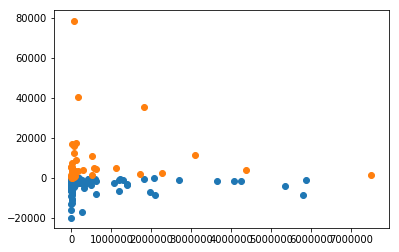

In [572]:
#Look at the distribution of losss and losses
x_loss = useful_trades[loss_perc_useful_mask].trade_duration.values
y_loss = useful_trades[loss_perc_useful_mask].realized.values
y_loss = y_loss.astype(np.int64)
y_loss = (np.sort(y_loss,axis=-1))
# print(y_loss)
plt.scatter(x_loss,y_loss) 
# win distribution
x_win = useful_trades[win_perc_useful_mask].trade_duration.values
y_win = useful_trades[win_perc_useful_mask].realized.values
y_win = y_win.astype(np.int64)
y_win = (np.sort(y_win,axis=-1))
# print(y_win)
plt.scatter(x_win,y_win) 

In [573]:
# General metrics
# date range
first_day = parser.parse(trades.opendt.values[-1])
last_day = parser.parse(trades.opendt.values[0])
print('time period',first_day - last_day)
# how many trades per day
average_trades_per_day = 0
unique_days = 1
day_count = 0
current_day = parser.parse(trades.opendt[0])
for row in trades.opendt:
    day = parser.parse(row)
    if day.day == current_day.day:
        day_count += 1
    else:
        average_trades_per_day += day_count
        current_day = day
        day_count = 0
        unique_days += 1
average_trades_per_day = average_trades_per_day / unique_days
print('average_trades_per_day',average_trades_per_day)
# average trade length
print('number of trades',trades.shape[0])
trade_times = []
for idx in range(trades.shape[0]):
    trade_open = parser.parse(trades.opendt[idx])
    trade_close = parser.parse(trades.closedt[idx])
    trade_time = trade_close - trade_open
    trade_times.append(trade_time)
durations = [h.total_seconds() for h in trade_times]
# trade length correlated with winning %
# trade length correlated with gain amount


time period 490 days, 23:00:32
average_trades_per_day 11.392712550607287
number of trades 3062


In [574]:
print(min(durations))
print(durations[0])
print(durations.count(195.0))
duration_counts_dict = {}
duration_counts = []
unique_durations = set(durations)
print(len(unique_durations))
print(len(durations))
for duration in unique_durations:
    temp_count = durations.count(duration)
    duration_counts.append(temp_count)
    duration_counts_dict[duration] = temp_count
    

0.0
195.0
5
2187
3062


In [575]:
print('Longest trade',max(trade_times))
print('Shortest trade',min(trade_times))
print('Mean trade',np.sum(trade_times)/len(trade_times))

Longest trade 214 days, 20:44:22
Shortest trade 0:00:00
Mean trade 1 day, 23:34:39.645003


523356819.0
523356819.0
(2187,) (2187,)


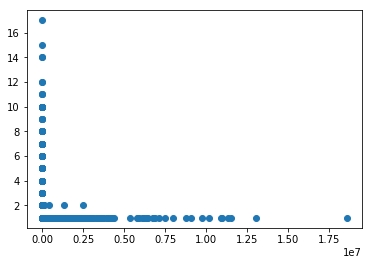

In [576]:
# x = np.arange(3)
# plt.bar(x, height= [1,2,3]) 
# plt.xticks(x, ['a','b','c'])
# y = np.linspace(0,max(duration_counts),len(duration_counts))
y = np.array(list(duration_counts_dict.values()))
# x = np.array(list(duration_counts_dict.keys()).sort())
x = np.array(sorted(list(duration_counts_dict.keys())))
print(sum(sorted(list(duration_counts_dict.keys()))))
print(sum(sorted(list(duration_counts_dict.keys()))))
print(x.shape,y.shape)
# print(x)
plt.scatter(x,y) 
# plt.scatter(x,y) 
# plt.scatter(x,y) 
# plt.xticks(x, ['a','b','c'])
# plt.figure(figsize=(14,6))
# _ = plt.hist(trade_times.astype(float), bins=100)

In [577]:
print(swing_trades.shape)
print(useful_trades.shape)

(686, 221)
(1884, 221)


In [578]:
sector_dict = {}
industry_dict = {}
volatility_dict = {}
volatility_finiz_dict = {}
volatility_hilo_dict = {}
# Swap this out to get industry/sector for any dataset
for index, row in swing_trades.iterrows():
#     try:
    stock_index = get_stock_index(row[2])
    stock = finiz.loc[stock_index]
    quantity = row[3]
    result = row[6]
    average_entry_price = row[9]
    stock_high = row[32]
    stock_low = row[33]
    atr14 = row[37]
    ## Volatility data
    volatility_finiz = float(stock['Volatility (Month)'])
    volatility_trade = atr14 / average_entry_price
    volatility_trade_hilo = (stock_high - stock_low) / average_entry_price
    ## Sector and Industry data 
    if stock.Sector in sector_dict:
        sector_dict[stock.Sector]['result'] += result
        sector_dict[stock.Sector]['count'] += 1
        sector_dict[stock.Sector]['quantity'] += quantity
#         np.vstack((sector_dict[stock.Sector]['trades'],row.values))
        sector_dict[stock.Sector]['trades'].append(row)
    else:
        print(stock.Sector)
        sector_dict[stock.Sector] = {'result':result, 'count':1,'quantity':quantity,'trades':[row]}
    if stock.Industry in industry_dict:
        industry_dict[stock.Industry]['result'] += result
        industry_dict[stock.Industry]['count'] += 1
        industry_dict[stock.Industry]['quantity'] += quantity
        industry_dict[stock.Industry]['trades'].append(row)
    else:
        industry_dict[stock.Industry] = {'result':result, 'count':1,'quantity':quantity,
                                         'trades':[row]}
    ###
    finiz_key = hash(round(volatility_finiz, 1))
    volatility_key = hash(round(volatility_trade, 4))
    hilo_key = hash(round(volatility_trade_hilo, 4))
    if finiz_key in volatility_finiz_dict:
        volatility_finiz_dict[finiz_key]['result'] += result
        volatility_finiz_dict[finiz_key]['count'] += 1
    else:
        volatility_finiz_dict[finiz_key] = {'result':result,'volatility':volatility_finiz,'count':1}
    ## Vanila volatility
    if volatility_key in volatility_dict:
        volatility_dict[volatility_key]['result'] += result
        volatility_dict[volatility_key]['count'] += 1
    else:
        volatility_dict[volatility_key] = {'result':result,'volatility':volatility_trade,'count':1}
    ## hilo volatility
    if hilo_key in volatility_hilo_dict:
        volatility_hilo_dict[hilo_key]['result'] += result
        volatility_hilo_dict[hilo_key]['count'] += 1
    else:
        volatility_hilo_dict[hilo_key] = {'result':result,'volatility':volatility_trade_hilo,'count':1}
#     except:
#         pass

Services
Technology
Consumer Goods
Industrial Goods


In [579]:
print(sector_dict.keys())
print(sector_dict['Technology'].keys())
print(len(sector_dict['Technology']['trades']))

dict_keys(['Services', 'Technology', 'Consumer Goods', 'Industrial Goods'])
dict_keys(['result', 'count', 'quantity', 'trades'])
366


In [580]:
# print(volatility_finiz_dict)
# for key,value in enumerate(sector_dict):
#     print(sector_dict[value])
## Volatility
# [print(volatility_finiz_dict[value]) for key,value in enumerate(volatility_finiz_dict)]
volatility_finiz_y = [volatility_finiz_dict[value]['result']/volatility_finiz_dict[value]['count'] for key,value in enumerate(volatility_finiz_dict)]
volatility_finiz_x = [volatility_finiz_dict[value]['volatility'] for key,value in enumerate(volatility_finiz_dict)]
volatility_y = [volatility_dict[value]['result']/volatility_dict[value]['count'] for key,value in enumerate(volatility_dict)]
volatility_x = [volatility_dict[value]['volatility'] for key,value in enumerate(volatility_dict)]
volatility_hilo_y = [volatility_hilo_dict[value]['result']/volatility_hilo_dict[value]['count'] for key,value in enumerate(volatility_hilo_dict)]
volatility_hilo_x = [volatility_hilo_dict[value]['volatility'] for key,value in enumerate(volatility_hilo_dict)]
## Sector and industry
sector_y = [sector_dict[value]['result']/sector_dict[value]['count'] for key,value in enumerate(sector_dict)]
sector_x = [value for key,value in enumerate(sector_dict)]
industry_y = [industry_dict[value]['result']/industry_dict[value]['count'] for key,value in enumerate(industry_dict)]
industry_x = [value for key,value in enumerate(industry_dict)]

In [581]:
# calculate average return for all sectors
for sector in sector_dict:
    print(sector)
    results = []
    quantities = []
    stock_names = {}
    stocks = []
    for trade in sector_dict[sector]['trades']:
        results.append(int(trade.realized))
        quantities.append(int(trade.quantity))
        symbol = trade.symbol
        if symbol not in stock_names:
            stocks.append(symbol)
            stock_names[symbol] = 1
    per_share = [results[idx] / quantities[idx] for idx in range(len(results))]
    results = sorted(results)
    if results[-1] > 2 * results[-2]:
        del results[-1]
    if results[0] < 2 * results[1]:
        del results[0]
#     print(results[-5:])
#     print(results[:5])
#     print('total result',sum(results))
    sector_result = sum(results) / sector_dict[sector]['quantity']
#     print('per share',sector_result)
    print('mean return',sum(per_share)/len(per_share))
    print('std',np.std(np.array(per_share)))
    print('mad',mad(per_share))
    print(stocks)

Services
mean return 0.033413248632603976
std 1.4866219826462697
mad 0.908184817272855
['KR', 'TITN', 'NFLX', 'CNET', 'NXTD', 'WTW', 'PFMT', 'TSG', 'CATM', 'BOOT', 'VIAB', 'EXPE', 'WBA', 'SHAK', 'UEPS', 'VRSK', 'ROKU', 'QUAD', 'CAKE', 'CAR', 'STN', 'GNC', 'HTZ', 'WBAI', 'DESP', 'SPEX', 'SIG', 'TLRD', 'HUD', 'BABA', 'BKS', 'BKE', 'FIVE', 'OMEX', 'BGI', 'BBBY', 'KTOS', 'SPOT', 'IMTE', 'COST', 'BLNK', 'SGMS', 'PENN', 'BYD', 'IGT', 'HD', 'AMCX', 'OMC', 'GPS', 'LABL', 'TLYS', 'CARS', 'JILL', 'EXPR', 'BIG', 'DDE', 'HUYA', 'WEN', 'MTN', 'SFIX', 'CONN', 'CHTR', 'ETSY', 'DIS', 'ULTA', 'GME', 'NEW', 'SBUX', 'DPZ', 'DNKN', 'CMG', 'ROST', 'YVR', 'IPG', 'WWE', 'MMYT', 'FISV', 'CMCSA', 'MGM', 'CZR', 'WYNN', 'TIVO', 'TPNL', 'HYRE', 'AQ', 'RBZ', 'CECO', 'CVNA', 'PZZA', 'HMHC', 'LYV', 'CTRP', 'HCSG', 'TECD', 'MGA', 'FLNT', 'FRSH', 'SCVL', 'ARCI', 'LOW', 'ADS']
Technology
mean return 0.29200775612959173
std 2.465346304831681
mad 1.27250623412963
['FB', 'SQ', 'FNSR', 'DPW', 'XNET', 'QD', 'GOOG', 'NTNX', 

In [582]:
sector_dict.keys()
# industry_dict['Semiconductor- Memory Chips']
# sector_dict['Semiconductor - Memory Chips']

dict_keys(['Services', 'Technology', 'Consumer Goods', 'Industrial Goods'])

In [583]:
# formula for displaying and saving correlation matricies
def save_correlations(dictionary,path):
    count = 1
    for industry in dictionary:
        results = []
        quantities = []
        stock_names = {}
        stocks = []
        for trade in dictionary[industry]['trades']:
            results.append(trade.realized)
            quantities.append(trade.quantity)
            symbol = trade.symbol
            if symbol not in stock_names:
                stocks.append(symbol)
                stock_names[symbol] = 1
        per_share = [results[idx] / quantities[idx] for idx in range(len(results))]
        results = sorted(results)
        if len(results) > 25:
            print(industry)
            if results[-1] > 2 * results[-2]:
                del results[-1]
            if results[0] < 2 * results[1]:
                del results[0]
            sector_result = sum(results) / dictionary[industry]['quantity']
            corr = pd.DataFrame(dictionary[industry]['trades'])
            labels = list(corr.columns)
            cmap = 'coolwarm'
            corr.style.background_gradient(cmap, axis=1)\
                .set_properties(**{'max-width': '500px', 'font-size': '50pt'})\
                .set_caption("Hover to magify")\
                .set_precision(2)\
                .set_table_styles(magnify())
            csv_file = corr.corr()
            csv_file.to_csv(path + industry + '.csv')
            plt.figure(num=count, figsize=(16, 16), dpi=40, facecolor='w', edgecolor='k')
            plt.matshow(corr.corr(method='pearson', min_periods=1),fignum=count)
            plt.show()
            count += 1


# for industry in industry_dict:
#     results = []
#     quantities = []
#     stock_names = {}
#     stocks = []
#     for trade in industry_dict[industry]['trades']:
#         results.append(trade.realized)
#         quantities.append(trade.quantity)
#         symbol = trade.symbol
#         if symbol not in stock_names:
#             stocks.append(symbol)
#             stock_names[symbol] = 1
#     per_share = [results[idx] / quantities[idx] for idx in range(len(results))]
#     results = sorted(results)
#     if len(results) > 25:
#         print(industry)
#         if results[-1] > 2 * results[-2]:
#             del results[-1]
#         if results[0] < 2 * results[1]:
#             del results[0]
#         sector_result = sum(results) / industry_dict[industry]['quantity']
#         corr = pd.DataFrame(industry_dict[industry]['trades'])
#         labels = list(corr.columns)
#         cmap = 'coolwarm'
#         corr.style.background_gradient(cmap, axis=1)\
#             .set_properties(**{'max-width': '500px', 'font-size': '50pt'})\
#             .set_caption("Hover to magify")\
#             .set_precision(2)\
#             .set_table_styles(magnify())
#         csv_file = corr.corr()
#         csv_file.to_csv('/Users/morgan/Documents/Ryan_correlations/Industry/' + industry + '.csv')
#         plt.figure(num=count, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
#         plt.matshow(corr.corr(method='pearson', min_periods=1),fignum=count)
#         plt.show()
#         count += 1
#         corr.style.apply(background_gradient,axis=None)
#         plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
#         plt.yticks(np.arange(0.5, len(corr[useful_columns]), 1), corr[useful_columns])
#         plt.xticks(np.arange(0.5, len(corr[useful_columns]), 1), corr[useful_columns])
#         plt.pcolormesh(corr)
#         plt.show()
#         correlation_matrix(corr[target_columns],target_columns)

By Industry
Internet Information Providers


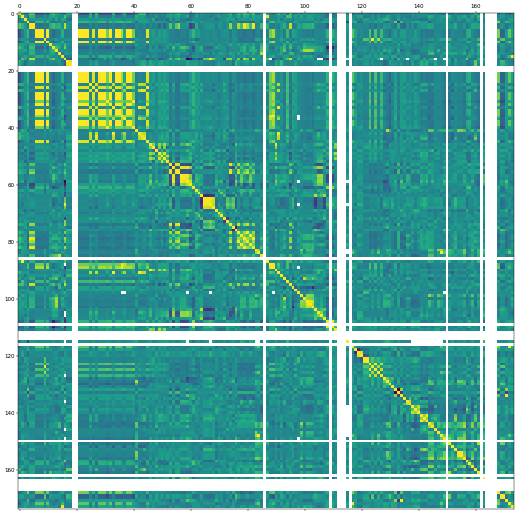

CATV Systems


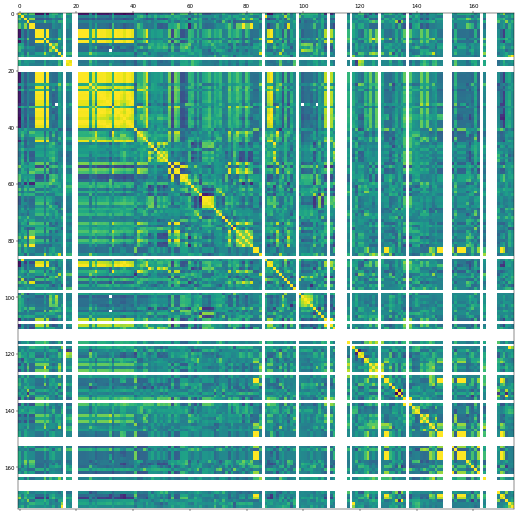

Internet Software & Services


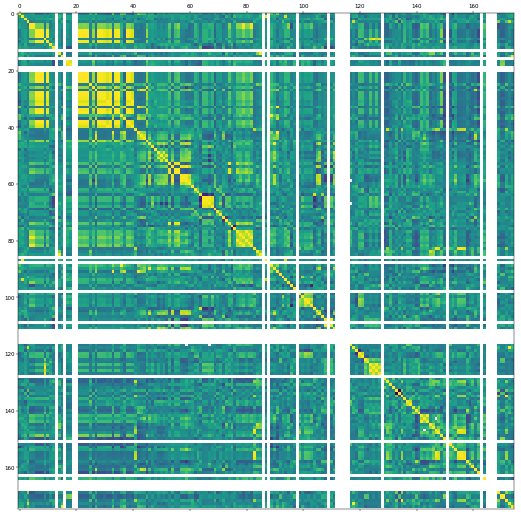

Communication Equipment


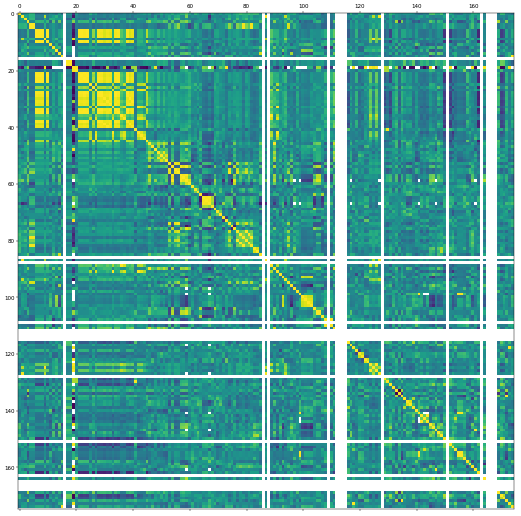

Application Software


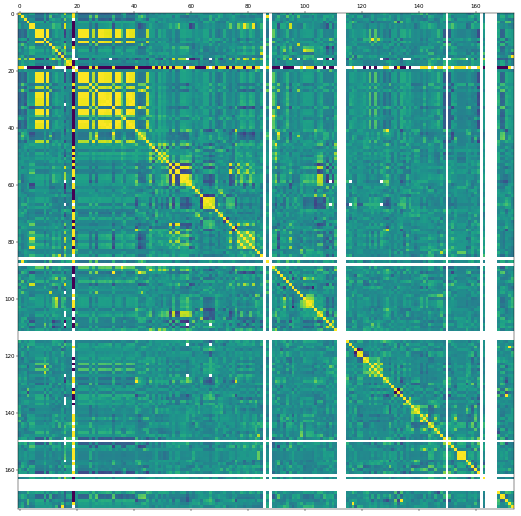

Auto Manufacturers - Major


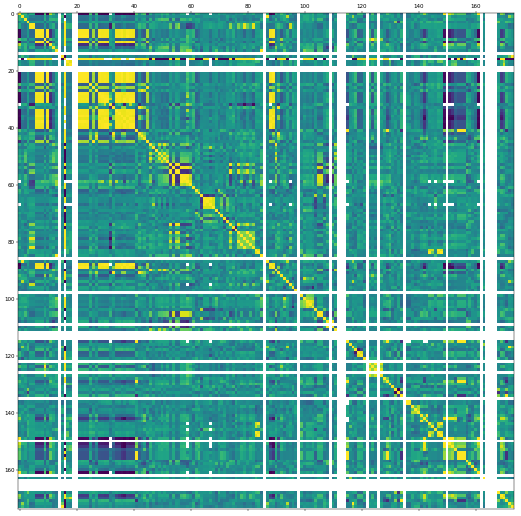

By Sector
Services


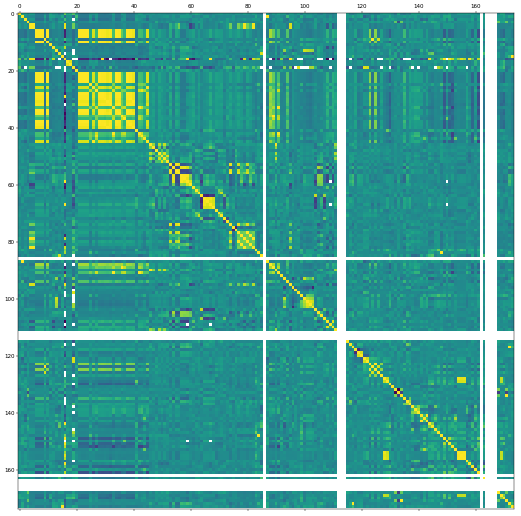

Technology


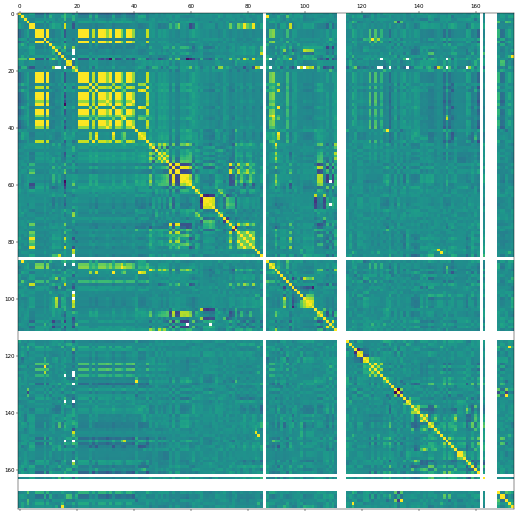

Consumer Goods


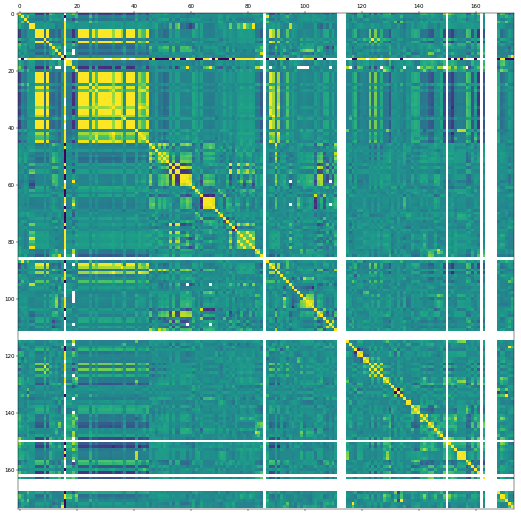

In [584]:
#Show and save correlation matricies by sector and industry
industry_path = '/Users/morgan/Documents/Ryan_correlations/Industry/'
sector_path = '/Users/morgan/Documents/Ryan_correlations/Sector/'
print('By Industry')
save_correlations(industry_dict,industry_path)
print('By Sector')
save_correlations(sector_dict,sector_path)

distribution mean 0.0006158399468019439
distribution std 0.05364819390694541


[]

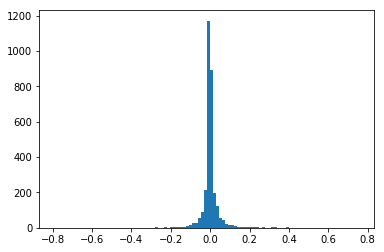

In [585]:
# Look at distribution of percent_gain feature
print('distribution mean',np.mean(trades['percent_gain']))
print('distribution std',np.std(trades['percent_gain']))
plt.hist(trades['percent_gain'].values,bins=100)
plt.plot()

[361 285 145  86  73  37  35  27  18   9   9   8  11   7   3   4   5   4
   3   1   3   3   5   2   2   1   1   1   1   2   2   2   1   1   1   1]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.31
 0.32 0.33 0.39 0.4  0.42 0.46 0.65 0.76]


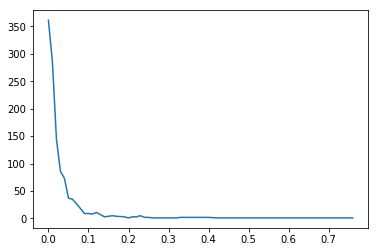

In [586]:
positive_mask = pd.to_numeric(trades['percent_gain'] > 0)
positive_values = trades['percent_gain'][positive_mask].round(2).values
# plt.hist(useful_trades['percent_gain'][positive_mask].values,bins=50)
# plt.plot()
x = sorted(positive_values)
pos_unique, pos_counts = np.unique(positive_values, return_counts=True)
# y = counts
# uniqw, inverse = np.unique(positive_values, return_inverse=True)
# print(np.bincount(inverse))
print(pos_counts)
print(pos_unique)
# print(x)
# p30 = np.poly1d(np.polyfit(unique, counts, 30))
# xp = np.linspace(0,max(counts),len(counts))
# _ = plt.plot(unique,counts, '.', xp, p30(xp), '-', xp, p30(xp), '--')
# plt.ylim(-2,2)
plt.plot(pos_unique,pos_counts)
plt.show()

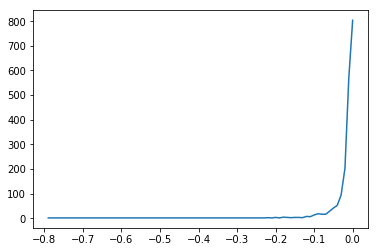

In [587]:
negative_mask = pd.to_numeric(trades['percent_gain'] <= 0)
# plt.hist(useful_trades['percent_gain'][negative_mask].values,bins=50)
# plt.plot()
negative_values = trades['percent_gain'][negative_mask].round(2).values
x = sorted(negative_values)
neg_unique, neg_counts = np.unique(negative_values, return_counts=True)
plt.plot(neg_unique,neg_counts)
plt.show()

In [588]:
#Check percentages of the distribution. How often does a particular stop get triggered.
#Goal is to generate a graph where we can plot the likelyhood of a stop getting triggered based on where you put it.

# print(neg_unique,neg_counts)
neg_sum_counts = sum(neg_counts)
pos_sum_counts = sum(pos_counts)
total_sum_counts = neg_sum_counts + pos_sum_counts
print('neg,pos, and total sums',neg_sum_counts,pos_sum_counts,total_sum_counts)
negative_freqs = []
positive_freqs = {}
total_distribution_freqs = {}

total_counts = np.concatenate([neg_counts,pos_counts])
total_uniques = np.concatenate([neg_unique,pos_unique])
print('total_counts',total_counts)
print('total_uniques',total_uniques)

negative_freqs = [neg_counts[idx]/neg_sum_counts for idx in range(len(neg_unique))]
negative_freq_dict = {neg_unique[idx]:sum(negative_freqs[:idx]) for idx in range(len(neg_unique))}

positive_freqs = [pos_counts[idx]/pos_sum_counts for idx in range(len(pos_unique))]
positive_freq_dict = {pos_unique[idx]:sum(positive_freqs[:idx]) for idx in range(len(pos_unique))}

total_freqs = [total_counts[idx]/total_sum_counts for idx in range(len(total_uniques))]
total_distribution_sums_freqs = {total_uniques[idx]:sum(total_freqs[:idx]) for idx in range(len(total_uniques))}

total_distribution_freqs = {total_uniques[idx]:total_freqs[idx] for idx in range(len(total_uniques))}

neg,pos, and total sums 1902 1160 3062
total_counts [  1   1   1   1   1   1   1   1   1   1   1   2   1   3   1   4   3   2
   3   3   2   7   6  13  18  16  16  28  41  52  94 202 570 804 361 285
 145  86  73  37  35  27  18   9   9   8  11   7   3   4   5   4   3   1
   3   3   5   2   2   1   1   1   1   2   2   2   1   1   1   1]
total_uniques [-0.79 -0.48 -0.43 -0.4  -0.36 -0.33 -0.3  -0.28 -0.27 -0.26 -0.23 -0.22
 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1
 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 -0.    0.    0.01
  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12  0.13
  0.14  0.15  0.16  0.17  0.19  0.2   0.21  0.22  0.23  0.24  0.25  0.26
  0.27  0.31  0.32  0.33  0.39  0.4   0.42  0.46  0.65  0.76]


In [589]:
# Dictionary of percentage gain/loss and percent of useful trades

# negative_freq_dict
# positive_freq_dict
# total_distribution_freqs
total_distribution_sums_freqs

{-0.79: 0,
 -0.48: 0.00032658393207054214,
 -0.43: 0.0006531678641410843,
 -0.4: 0.0009797517962116264,
 -0.36: 0.0013063357282821686,
 -0.33: 0.0016329196603527107,
 -0.3: 0.001959503592423253,
 -0.28: 0.0022860875244937948,
 -0.27: 0.002612671456564337,
 -0.26: 0.0029392553886348795,
 -0.23: 0.003265839320705422,
 -0.22: 0.003592423252775964,
 -0.21: 0.004245591116917049,
 -0.2: 0.004572175048987591,
 -0.19: 0.0055519268451992175,
 -0.18: 0.00587851077726976,
 -0.17: 0.007184846505551928,
 -0.16: 0.008164598301763555,
 -0.15: 0.00881776616590464,
 -0.14: 0.009797517962116267,
 -0.13: 0.010777269758327894,
 -0.12: 0.011430437622468979,
 -0.11: 0.013716525146962774,
 -0.1: 0.015676028739386026,
 -0.09: 0.019921619856303075,
 -0.08: 0.025800130633572834,
 -0.07: 0.03102547354670151,
 -0.06: 0.03625081645983018,
 -0.05: 0.04539516655780536,
 -0.04: 0.05878510777269759,
 -0.03: 0.07576747224036579,
 -0.02: 0.10646636185499675,
 -0.01: 0.17243631613324625,
 -0.0: 0.6211626387981711,
 0.01:

In [590]:
#Checking instances of the levered column
is_lev_mask = trades['is_lev'] == 1
# print(is_lev_mask)
print(trades.loc[is_lev_mask])
print(trades.shape)

      idsym                    opendt symbol  quantity  is_long  \
630    1038  2018-02-21T19:30:06.000Z    TBT    3000.0        1   
1188    187  2018-04-09T19:55:57.000Z    FAS    3000.0        0   
1224   9097  2018-04-16T18:26:56.000Z   RUSL    1950.0        1   

                       closedt  realized  open_fill_id  close_fill_id  \
630   2018-03-05T14:54:01.000Z   -1693.0     151720916      152181549   
1188  2018-04-10T15:07:32.000Z   -6193.5     154010912      154060544   
1224  2018-04-16T19:00:05.000Z    1532.0     154255394      154255393   

      average_entry_price      ...        ultra  lev  is_lev use?  \
630             39.358000      ...            1    2       1  0.0   
1188            62.142333      ...            1    3       1  0.0   
1224            39.541026      ...            1    3       1  0.0   

     per_share_return atr14_percent atr14_lag_percent  percent_gain  \
630         -0.564333      0.024151          0.023136     -0.014338   
1188        -2.0645

In [591]:
for index,value in enumerate(sector_dict):
    print(index,value)
sector_dict['Industrial Goods'].keys()
print(sector_dict['Technology']['quantity'])
print(sector_dict['Consumer Goods']['count'])
print(sector_dict['Technology']['result'])
# held = 0
# not_held = 0
# for trade in sector_dict['Consumer Goods']['trades']:
#     if trade['held_overnight'] == 1:
#         held += 1
#     else:
#         not_held += 1
# total_held = held + not_held
# print(held / total_held ,not_held / total_held)
    
    
held = 0
not_held = 0
total_held = 0 
for trade in sector_dict['Services']['trades']:
    if trade['held_overnight'] == 1:
        held += 1
    else:
        not_held += 1

total_held = held + not_held
print(held / total_held ,not_held / total_held)
print(held,not_held)

0 Services
1 Technology
2 Consumer Goods
3 Industrial Goods
1665063.66666666
124
114264.29819999998
0.44808743169398907 0.5519125683060109
82 101


In [592]:
for stock in sector_dict:
    print(stock)

Services
Technology
Consumer Goods
Industrial Goods


In [593]:
#calculate instances of trades in a given day
beginning_day = parser.parse(useful_trades.opendt.values[0]).day
day_dictionary = {}
totals_dictionary = {}
print('first day',beginning_day)
for trade in range(useful_trades.shape[0]):
#     print('idx',trade)
    #check if day matches then accrue all trades that day of each stock
    current_day = parser.parse(useful_trades.opendt.values[trade]).day
#     print('days',current_day,beginning_day)
    if current_day != beginning_day:
#         print('new day')
        beginning_day = current_day
        #add day totals to totals_dictionary
        for stock in day_dictionary:
#             print(stock)
            for index,value in enumerate(day_dictionary[stock]):
                key = index+1
                if key in totals_dictionary:
                    totals_dictionary[key]['value'] += value
                    totals_dictionary[key]['count'] += 1
                else:
                    totals_dictionary[key] = { 'value':value,'count':1}
        #clear dictionary
        day_dictionary = {}
        ticker = useful_trades['symbol'].values[trade]
        gain = useful_trades['per_share_return'].values[trade]
        day_dictionary[ticker] = [gain]
#         print(totals_dictionary)
    else:
        ticker = useful_trades['symbol'].values[trade]
        gain = useful_trades['per_share_return'].values[trade]
#         print(ticker,gain)
        if ticker in day_dictionary:
            day_dictionary[ticker].append(gain)
        else:
            day_dictionary[ticker] = [gain]
        

first day 30


In [594]:
# Per share return based on how many trades in that stock in a given day
for key in totals_dictionary:
    totals_dictionary[key]['total'] = totals_dictionary[key]['value'] / totals_dictionary[key]['count']
totals_dictionary

{1: {'value': 182.49611528295566, 'count': 1331, 'total': 0.1371120325191252},
 2: {'value': 30.795290690091054, 'count': 292, 'total': 0.10546332428113375},
 3: {'value': 16.94135628076323, 'count': 112, 'total': 0.1512621096496717},
 4: {'value': -14.584009915322458, 'count': 58, 'total': -0.25144844681590445},
 5: {'value': 9.205135846793986, 'count': 35, 'total': 0.26300388133697106},
 6: {'value': -6.565234456657567, 'count': 18, 'total': -0.3647352475920871},
 7: {'value': -6.047751533328774, 'count': 13, 'total': -0.4652116564099057},
 8: {'value': -11.15327182340648, 'count': 8, 'total': -1.39415897792581},
 9: {'value': 0.7166199999999999, 'count': 2, 'total': 0.35830999999999996},
 10: {'value': 0.0003166666666666318,
  'count': 2,
  'total': 0.0001583333333333159},
 11: {'value': -0.175489, 'count': 2, 'total': -0.0877445},
 12: {'value': 0.39308, 'count': 2, 'total': 0.19654},
 13: {'value': -0.50213, 'count': 2, 'total': -0.251065},
 14: {'value': -0.51667, 'count': 2, 'to

In [595]:
# To sort the list in place...
# industry_dict.sort(key=lambda x: x.count, reverse=True)

# To return a new list, use the sorted() built-in function...
# newlist = sorted(industry_dict, key=lambda x: x.result, reverse=True)
# print(newlist)

[69.61682002094926] 1020.2107986896972 [-56.980347336806354] [530.9913069202898] [493.25273146832444]


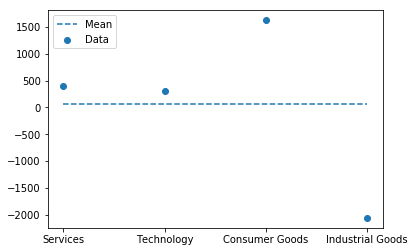

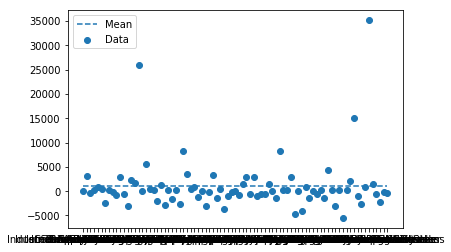

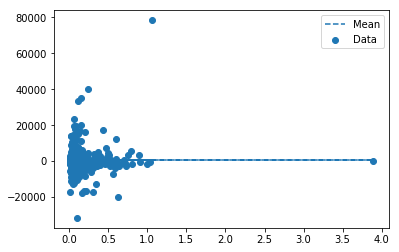

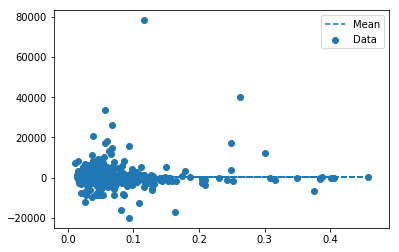

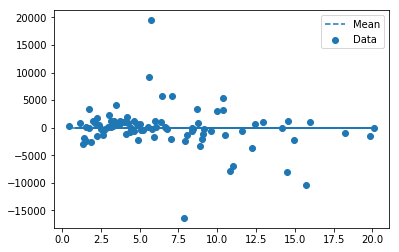

In [596]:
# print(sector_x)
# print(sector_y)
# plt.figure(figsize=(14,6))
# plt.scatter(sector_x,sector_y)
# plt.figure(figsize=(14,6))
# plt.scatter(industry_x,industry_y)
###
industry_mean = [np.mean(industry_y) for i in industry_y]
sector_mean = [[np.mean(sector_y)] for i in sector_y]
finiz_mean = [[np.mean(volatility_finiz_y)] for i in volatility_finiz_y]
volatility_mean = [[np.mean(volatility_y)] for i in volatility_y]
hilo_mean = [[np.mean(volatility_hilo_y)] for i in volatility_hilo_y]
print(sector_mean[0],industry_mean[0],finiz_mean[0],volatility_mean[0],hilo_mean[0])
fig,ax = plt.subplots()

# Plot the data
data_line = ax.scatter(sector_x,sector_y, label='Data', marker='o')

# Plot the average line
mean_line = ax.plot(sector_x,sector_mean, label='Mean', linestyle='--')

# Make a legend
legend = ax.legend(loc='upper left')
plt.show()

fig,ax = plt.subplots()

# Plot the data
data_line = ax.scatter(industry_x,industry_y, label='Data', marker='o')

# Plot the average line
mean_line = ax.plot(industry_x,industry_mean, label='Mean', linestyle='--')

# Make a legend
legend = ax.legend(loc='upper left')

plt.show()
###
# Variance
###
fig,ax = plt.subplots()

# Plot the data
data_line = ax.scatter(volatility_hilo_x,volatility_hilo_y, label='Data', marker='o')

# Plot the average line
mean_line = ax.plot(volatility_hilo_x,hilo_mean, label='Mean', linestyle='--')

# Make a legend
legend = ax.legend(loc='upper right')

plt.show()
###
fig,ax = plt.subplots()

# Plot the data
data_line = ax.scatter(volatility_x,volatility_y, label='Data', marker='o')

# Plot the average line
mean_line = ax.plot(volatility_x,volatility_mean, label='Mean', linestyle='--')

# Make a legend
legend = ax.legend(loc='upper right')

plt.show()
###
fig,ax = plt.subplots()

# Plot the data
data_line = ax.scatter(volatility_finiz_x,volatility_finiz_y, label='Data', marker='o')

# Plot the average line
mean_line = ax.plot(volatility_finiz_x,finiz_mean, label='Mean', linestyle='--')

# Make a legend
legend = ax.legend(loc='upper right')

plt.show()

In [597]:
# Display R values of the volatility metric based on various ways of calculating it

mask = ~np.isnan(volatility_x) & ~np.isnan(volatility_y)
mask_2 = ~np.isnan(volatility_hilo_x) & ~np.isnan(volatility_hilo_y)
vol_index = np.where(mask==False)[0][0]
vol2_index = np.where(mask_2==False)[0][0]
print(vol_index)
print(vol2_index)
del volatility_x[vol_index]
del volatility_y[vol_index]
del volatility_hilo_x[vol2_index]
del volatility_hilo_y[vol2_index]
print(linregress(volatility_finiz_x, volatility_finiz_y))
print(linregress(np.array(volatility_x), np.array(volatility_y)))
print(linregress(volatility_hilo_x, volatility_hilo_y))

176
177
LinregressResult(slope=-174.40245938517572, intercept=1115.7572812607377, rvalue=-0.20420501044566966, pvalue=0.05634155691363972, stderr=90.15458127278296)
LinregressResult(slope=3535.0254858081694, intercept=292.11347464376263, rvalue=0.03706770364333563, pvalue=0.4282114633289714, stderr=4458.001377401294)
LinregressResult(slope=2017.4621203428883, intercept=225.11376414656752, rvalue=0.07134633925813162, pvalue=0.09107333404724156, stderr=1191.8772043590309)


# Ryan's Trading Data


+ Time span : 490 days, 23:00:32
+ Number of trades : 3062
+ Average Number of trades per day : 11.39
+ Winning frequency: 37%
+ Losing frequency: 62%
+ Average win : 2547
+ Average loss : 1252
+ Average per trade return : 189
+ Longest trade : 214 days, 20:44:22
+ Shortest trade : 0 seconds

### Average return for useful trades by sector

() represents data with outliers

*Consumer Goods*
+ Average Return: 501 (790.2)
+ Trade instances: 270
+ Per share stats:
+ + Per share return: 0.18 (0.288)
+ + mean return 0.03858337869614742
+ + std 2.1049901853307573
+ + mad 1.2388000295034434
['LULU', 'FIZZ', 'TSLA', 'KODK', 'FTFT', 'GM', 'PBI', 'NHTC', 'AAPL', 'BG', 'MAT', 'HAS', 'IP', 'HOG', 'HLF', 'SAFM', 'RFP', 'GPRO', 'IRBT', 'BLL', 'COTY', 'EPC', 'GOOS', 'SPB', 'NWL', 'MPAA', 'ICON', 'UAA', 'FOSL', 'UA', 'SNBR', 'CPB', 'NAV', 'FNKO', 'VUZI', 'CALM', 'ETH', 'PM', 'MO', 'CLW', 'ELY', 'VSTO', 'FCAU', 'REV', 'LZB', 'FORD', 'BGS', 'TAP', 'SJM', 'SKX', 'PETZ', 'PLAG', 'BUD', 'SOLO', 'TPX', 'BTI', 'TVPT', 'VFC', 'KBSF', 'HRL', 'TIS', 'DECK', 'NIO', 'FARM']

*Services*
+ Average Return: 160 (252.4)
+ Trade instances: 437
+ Per share stats:
+ + Per share return: 0.073 (0.115)
+ + mean return 0.08367928260470203
+ + std 1.5101002800075556
+ + mad 0.9059593947765603
['KR', 'NFLX', 'TITN', 'BABA', 'CNET', 'NXTD', 'ROKU', 'WTW', 'LOW', 'PFMT', 'CBS', 'VIAB', 'HRB', 'MARA', 'TSG', 'WYNN', 'CASY', 'SFLY', 'HD', 'CATM', 'EBAY', 'BOOT', 'JWN', 'EXPE', 'ULTA', 'WBA', 'GNC', 'SCI', 'IPG', 'WEN', 'SHAK', 'UEPS', 'DPZ', 'VRSK', 'HUBG', 'QUAD', 'CBRL', 'CAKE', 'CAR', 'HTZ', 'STN', 'CHTR', 'WBAI', 'ZAGG', 'COST', 'DESP', 'HGV', 'TLYS', 'SPEX', 'SIG', 'TLRD', 'HUD', 'CTRP', 'BKS', 'BKE', 'KTOS', 'FDX', 'FIVE', 'DXPE', 'OMEX', 'DSS', 'BGI', 'ONE', 'GME', 'RH', 'OLLI', 'SPOT', 'HLG', 'BBBY', 'MCD', 'MGM', 'PIR', 'SSTK', 'IMTE', 'BLNK', 'LBTYA', 'CZR', 'SGMS', 'PENN', 'BYD', 'IGT', 'HTHT', 'KSS', 'AMCX', 'OMC', 'GPS', 'LABL', 'CARS', 'LYV', 'GES', 'SPTN', 'JILL', 'EXPR', 'KIRK', 'BIG', 'DDE', 'ANF', 'HUYA', 'MTN', 'SFIX', 'CONN', 'ETSY', 'DIS', 'NEW', 'SBUX', 'PZZA', 'WMT', 'DNKN', 'DISH', 'TRCO', 'EEFT', 'ORLY', 'YUMC', 'CMG', 'GPX', 'LL', 'ROST', 'YVR', 'WWE', 'MMYT', 'FISV', 'GOLF', 'SEAS', 'CMCSA', 'GCI', 'TIVO', 'XPO', 'TPNL', 'HYRE', 'RBZ']

*Technology*
+ Average Return: 178 (170.9)
+ Trade instances: 845
+ Per share stats:
+ + Per share return: 0.061 (0.058)
+ + mean return 0.15962169178506477
+ + std 2.0493161134458213
+ + mad 1.0714548347585782
['FB', 'NTNX', 'NVDA', 'PANW', 'HUBS', 'FSLR', 'SQ', 'FNSR', 'DPW', 'XNET', 'QD', 'GOOG', 'EA', 'NETE', 'STX', 'FRSX', 'AKAM', 'NUAN', 'CCIH', 'HMNY', 'CDK', 'BIDU', 'INPX', 'QCOM', 'AVGO', 'LIVE', 'ADSK', 'PTC', 'TXN', 'RMBS', 'IBM', 'FEYE', 'LRCX', 'SPWR', 'IDT', 'SSTI', 'WDC', 'INTC', 'OLED', 'VMW', 'MXIM', 'WB', 'ANET', 'SHOP', 'TTD', 'AMD', 'SINA', 'PLT', 'CTXS', 'MKSI', 'NCTY', 'NOW', 'LITE', 'SNAP', 'MCHP', 'DGLY', 'MSFT', 'CRUS', 'MARK', 'YELP', 'GRUB', 'IAC', 'BR', 'UIS', 'RNG', 'TWLO', 'EIGI', 'CARB', 'TRUE', 'TRIP', 'PI', 'SEDG', 'SNCR', 'ANY', 'AAOI', 'TWTR', 'STMP', 'BAND', 'MOMO', 'HPE', 'MU', 'DATA', 'RUN', 'ACMR', 'SOHU', 'HPQ', 'OKTA', 'JD', 'AMAT', 'COUP', 'SILC', 'WIX', 'DDD', 'RUBI', 'ADBE', 'CSIQ', 'ZS', 'SGH', 'RHT', 'IDTI', 'HEAR', 'QNST', 'NXPI', 'ACIA', 'YNDX', 'DCAR', 'IZEA', 'LLNW', 'UCTT', 'MTCH', 'HCHC', 'SYNA', 'GRPN', 'I', 'SYMC', 'DBX', 'IQ', 'MIME', 'SWCH', 'ADP', 'ALTR', 'BOXL', 'TTWO', 'NTES', 'PLAB', 'BILI', 'CRM', 'DOCU', 'ZUO', 'TEAM', 'AMBA', 'CLDR', 'YY', 'VRNT', 'OCC', 'RFIL', 'NNDM', 'PVTL', 'BITA', 'JBL', 'JT', 'CLPS', 'PS', 'SATS', 'SMAR', 'AVLR', 'ABIL', 'AWSM', 'CNTF', 'CSCO', 'XRX', 'UBNT', 'CPAH', 'SWKS', 'TER', 'CVLT', 'NLSN', 'SCON', 'QLYS', 'AYI', 'CDNS', 'JNPR', 'COMM', 'DXC', 'ARRS', 'XLNX', 'PFPT', 'APH', 'VRNS', 'FIT', 'MAXR', 'GRVY', 'SSYS', 'VECO', 'VRSN', 'RP', 'Z', 'UPWK', 'MLNX', 'ANSS', 'ATVI', 'TCX', 'INTU', 'MTLS', 'FFIV', 'NPTN', 'SLAB', 'ZAYO', 'EGAN', 'RAMP', 'SVMK']

*Industrial Goods*
+ *Average Return:* 370 (-765.2)
+ *Trade instances:* 18
+ Per share stats:
+ + *Per share return:* 0.074 (-0.163)
+ + mean return 1.1544136445944986
+ + std 3.4246974526980067
+ + mad 2.404736971843354
['OSIS', 'GE', 'BLDP', 'GGG', 'SITE', 'DHR', 'EMR', 'SEII', 'ZBRA', 'WY', 'ROP', 'TBLTU']

### Average return for useful trades by industry

sorted by per share

*Auto Manufacturers - Major*
+ number of trades 119
+ total result 109908
+ per share 0.3931126244706421
+ mean return 0.03320715378030502
+ std 2.889791432144063
+ mad 1.9117028604442343
['TSLA', 'GM', 'FCAU', 'SOLO', 'NIO']

*Business Software & Services*
+ number of trades 27
+ total result 15736
+ per share 0.34242193450114244
+ mean return 0.05597747959070302
+ std 0.9856471713844153
+ mad 0.7172340799527638
['CTXS', 'MSFT', 'CARB', 'BAND', 'ADP', 'DOCU', 'VRNT', 'SMAR', 'FFIV', 'EGAN']

*CATV Systems*
+ number of trades 89
+ total result 33386
+ per share 0.223070035946708
+ mean return 0.07540924227698935
+ std 2.214225433248382
+ mad 1.39499546635727
['NFLX', 'ROKU', 'CHTR', 'IMTE', 'LBTYA', 'DISH', 'TIVO']

*Communication Equipment*
+ number of trades 45
+ total result 13728
+ per share 0.19597710174306557
+ mean return 0.36237964641478426
+ std 1.1150981850912185
+ mad 0.8288008616516234
['FNSR', 'QCOM', 'PLT', 'LITE', 'PI', 'HPE', 'SILC', 'HEAR', 'ACIA', 'BOXL', 'OCC', 'SATS', 'ABIL', 'AWSM', 'CNTF', 'CSCO', 'UBNT', 'JNPR', 'COMM', 'ARRS', 'MAXR', 'ZAYO']

*Semiconductor - Specialized*
+ number of trades 96
+ total result 26588
+ per share 0.16209131200809604
+ mean return 0.2400352059651284
+ std 2.1458710437510775
+ mad 1.4185579515163351
['NVDA', 'FSLR', 'SPWR', 'CRUS', 'SEDG', 'RUN', 'CSIQ', 'ALTR']

*Semiconductor - Broad Line*
+ number of trades 49
+ total result 38730
+ per share 0.12642608823385398
+ mean return 0.14610398818453826
+ std 0.7118521574061379
+ mad 0.5251304072503105
['AVGO', 'TXN', 'INTC', 'MXIM', 'AMD', 'MCHP', 'IDTI', 'NXPI', 'MLNX', 'NPTN']

*Application Software*
+ number of trades 133
+ total result 47600
+ per share 0.10892797480926163
+ mean return 0.2945271000791092
+ std 3.192741239999751
+ mad 1.4276287125249927
['HUBS', 'XNET', 'NUAN', 'CDK', 'INPX', 'FEYE', 'SSTI', 'SHOP', 'TTD', 'RNG', 'TWLO', 'EIGI', 'SNCR', 'ANY', 'STMP', 'DATA', 'RUBI', 'ADBE', 'RHT', 'DCAR', 'SYNA', 'DBX', 'MIME', 'CRM', 'ZUO', 'CLDR', 'PVTL', 'PS', 'AVLR', 'CPAH', 'CVLT', 'QLYS', 'CDNS', 'PFPT', 'RP', 'ANSS', 'INTU', 'MTLS', 'SVMK']

*Semiconductor- Memory Chips*
+ number of trades 39
+ total result 11807
+ per share 0.07136294953158054
+ mean return -0.008554921178341285
+ std 0.7210118044976411
+ mad 0.42039955623661013
['RMBS', 'MU', 'SGH']

*Information Technology Services*
+ number of trades 40
+ total result 5731
+ per share 0.05812609030792324
+ mean return 0.404451499330416
+ std 1.0244399179267887
+ mad 0.8230586311935392
['QD', 'HMNY', 'IBM', 'NOW', 'UIS', 'SWCH', 'TEAM', 'JT', 'CLPS', 'XRX', 'DXC', 'RAMP']

*Internet Information Providers*
+ number of trades 214
+ total result 22565
+ per share 0.045618482712889624
+ mean return 0.05777967980234797
+ std 2.3975689976310566
+ mad 1.3001269335177859
['FB', 'GOOG', 'AKAM', 'CCIH', 'BIDU', 'LIVE', 'WB', 'MARK', 'YELP', 'GRUB', 'IAC', 'TRIP', 'TWTR', 'SOHU', 'JD', 'WIX', 'YNDX', 'LLNW', 'MTCH', 'GRPN', 'IQ', 'BILI', 'YY', 'BITA', 'VRSN', 'Z', 'UPWK', 'TCX']

*Specialty Retail, Other*
+ number of trades 77
+ total result -1304
+ per share -0.007991959010566057
+ mean return -0.13078200048756441
+ std 0.861532686864699
+ mad 0.5626837218011679
['BABA', 'EBAY', 'ULTA', 'ZAGG', 'HUD', 'BKS', 'FIVE', 'PIR', 'SFIX', 'ETSY', 'RBZ']

*Internet Software & Services*
+ number of trades 68
+ total result -6263
+ per share -0.02059851801178092
+ mean return 0.051877717597090416
+ std 0.7329697539398508
+ mad 0.5273064575194221
['SQ', 'NETE', 'SINA', 'SNAP', 'MOMO', 'COUP', 'QNST', 'NTES']

*Electronic Equipment*
+ number of trades 41
+ total result -4981
+ per share -0.03028423772609819
+ mean return 0.0713641614784678
+ std 0.6235055154101247
+ mad 0.4925298304319038
['KODK', 'AAPL', 'VUZI']

*Technical & System Software*
+ number of trades 36
+ total result -23450
+ per share -0.24913413934513312
+ mean return -0.10941156953210793
+ std 1.1480634365740785
+ mad 0.80760433784565
['NTNX', 'ADSK', 'PTC', 'VMW', 'OKTA', 'VRNS']

*Entertainment - Diversified*
+ number of trades 48
+ total result -35465
+ per share -0.3211420395892569
+ mean return -0.2990172670921069
+ std 0.6050038461053822
+ mad 0.4139559753667947
['CBS', 'VIAB', 'AMCX', 'LYV', 'HUYA', 'DIS', 'YVR', 'WWE', 'CMCSA']

*Semiconductor Equipment & Materials*
+ number of trades 29
+ total result -16890
+ per share -0.3231237206098984
+ mean return -0.30574404657549137
+ std 1.6324115773991716
+ mad 1.0725667533803294
['LRCX', 'OLED', 'ACMR', 'AMAT', 'UCTT', 'PLAB', 'AMBA', 'TER', 'SCON', 'VECO']

### Average return for all trades by sector

*Consumer Goods*
+ Average Return: 808.9413919413919
+ Trade instances: 273

*Basic Materials*
+ Average Return: 770.8888888888889
+ Trade instances: 72

*Services*
+ Average Return: 303.9076923076923
+ Trade instances: 585

*Financial*
+ Average Return: 297.11042944785277
+ Trade instances: 163

*Technology*
+ Average Return: 156.5719298245614
+ Trade instances: 855

*Industrial Goods*
+ Average Return: -156.7941176470588
+ Trade instances: 68

*Healthcare*
+ Average Return: -219.67857142857142
+ Trade instances: 364

*Utilities*
+ Average Return: -1596.8148148148148
+ Trade instances: 27


## Charts

ticker variance compared to profitability


## Durations

##### For All Trades
| Time | Percentage of trades   |
|------|------|
|   2hr <  | 0.689|
|   1hr <  | 0.614|
|   30mins <  | 0.526|
|   15mins <  | 0.453|
|   7.5mins <  | 0.367|
|   3.75mins <  | 0.287|
|   1min <  | 0.139|

##### For 'Useful' Trades
| Time | Percentage of trades   |
|------|------|
|   2hr <  | 0.70|
|   1hr <  | 0.62|
|   30mins <  | 0.53|
|   15mins <  | 0.47|
|   7.5mins <  | 0.38|
|   3.75mins <  | 0.29|
|   1min <  | 0.14|


# Stats on Useful trading data
Selection Process
---
+ minimum loss: 0.02%
+ minimum gain: 0.08
+ minimum trade duration: 2 hours
---
+ Number of trades: 553
+ Positive trades: 274 
+ Negative trades: 278 
+ breakeven: 1
+ win%: 0.495
+ loss% 0.50
+ tie%: 0.0018
+ per share gain: 0.177
+ 712.98
+ total amount lost: -671589
+ average loss: -2415.78
+ total amount won: 1065870
+ average loss 3890
+ Win/Loss: 1.587
+ total shares traded: 2220121.66
+ total realized: 394281
+ max loss: -31585
+ max win: 78356
+ max loss percent: -0.358
+ max gain percent: 0.312


### Correlations
There is a false correlation between losses and time. Typically its because he got stopped out quickly, as opposed to being able to be in a trade for longer because he hasn't lost yet.

Finiz columns:
+ Dividend yield
+ Operating margin
+ Profit margin
+ Short interest %
+ Institutional own %
+ Market Cap
+ Debt/equity %


### Workflow

Stock ticker -> Variance -> Trade Type -> winning percent -> win/loss -> kelly criterion -> decision


### XGBoost

Predict stops and gains for wins/losses.

In [827]:
# initialize helper tools
enc = OneHotEncoder(handle_unknown='ignore')
le = LabelEncoder()
scaler = StandardScaler()
# finviz_pipeline = Pipeline([('scaler', StandardScaler()), ('encoder', LabelEncoder())])
# trades_pipeline = Pipeline([('scaler', StandardScaler()), ('encoder', LabelEncoder())])

In [851]:
# XGBoost functions

def return_data(data,categorical_columns,numerical_columns,target_column,fill_mean=False):
#     categorical_slice = data[categorical_columns]
    categorical_slice = data[categorical_columns].apply(le.fit_transform)
    numerical_slice = data[numerical_columns]
#     numerical_slice = data[numerical_columns].apply(scaler.fit_transform)
    scaler.fit(numerical_slice)
#     print(categorical_slice.shape,categorical_slice)
#     le.fit(categorical_slice)
    if fill_mean == True:
        numerical_slice.fillna(numerical_slice.mean(), inplace=True)
    numerical_slice = numerical_slice.round(2)
    scaled_data = pd.concat([categorical_slice,numerical_slice],axis=1)
    X = scaled_data.values
    y = data[target_column].values
    print('X',X.shape)
    print('y',y.shape)
    return split_data(X,y)

def split_data(X,y):
    # Vars for splitting data
    seed = 7
    test_size = 0.25
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    return X_train, X_test, y_train, y_test
    
def return_accuracy(model,X_test,y_test):
    y_pred = model.predict(X_test)
    print('predictions',y_pred[:5])
    distance = np.subtract(y_test,y_pred)
    #remove Nans
    distance = distance[~np.isnan(distance)]
    print('mean and std of distance',np.mean(distance),np.std(distance))
    print('distance',distance[:5])
    print('targets',y_test[:5])
    accuracy = np.sum(distance) / distance.shape[0]
    print("Average distance:" , accuracy)
    
def XGBoostTrain(X_train, X_test, y_train, y_test):
    param = {'verbosity':1, 'objective':'reg:gamma', 'booster':'gbtree', 'base_score':3}
#     watchlist = [(X_test, 'eval'), (X_train, 'train')]
    eval_set = [(X_train, y_train), (X_test, y_test)]
    eval_metric = ["rmse"]
    model = XGBRegressor(num_round = 30,
     learning_rate =0.08,
     n_estimators=1000,
     max_depth=4,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective='reg:linear',
     scale_pos_weight=1,
     seed=27)
    model.fit(X_train, y_train,eval_metric=eval_metric, eval_set=eval_set, verbose=True)
    print(model)
    return_accuracy(model,X_test,y_test)
    return model

def XGBoostTrainOnly(X_train, y_train):
#     param = {'silent':1, 'objective':'reg:gamma', 'booster':'gbtree', 'base_score':3}
#     watchlist = [(X_test, 'eval'), (X_train, 'train')]
    model = XGBRegressor(num_round = 30,
     learning_rate =0.01,
     n_estimators=1000,
     max_depth=3,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective='reg:linear',
     nthread=4,
     scale_pos_weight=1,
     seed=27)
    model.fit(X_train, y_train)
    return model
    
def return_uniques(values):
    unqiue, count = np.unique(values, return_counts=True)
    print(unqiue, count)
    return unqiue, count

def display_data(values):
    for i in range(values.shape[0]):
        print(type(values[i]))
        
def my_plot_importance(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

In [829]:
# XGBoost on finiz data predicting volatility
print(finiz.shape)
#take out weekly volatility and get train and test
data_set = finiz.drop(['Volatility (Week)','Earnings Date'],1)
# data_set = data_set.fillna('nan')
categorical_columns = ['Sector', 'Industry', 'Country','Sector.1', 'Industry.1']
numerical_columns = ['Market Cap', 'P/E', 'Forward P/E', 'PEG', 'P/S', 'P/B', 'P/Cash',
       'P/Free Cash Flow', 'Dividend Yield', 'EPS growth next year','EPS growth past 5 years', 'EPS growth next 5 years',
       'Sales growth past 5 years', 'EPS growth quarter over quarter',
       'Sales growth quarter over quarter', 'Shares Outstanding',
       'Shares Float', 'Institutional Ownership', 'Float Short', 'Short Ratio',
       'Return on Assets', 'Return on Equity', 'Return on Investment',
       'LT Debt/Equity', 'Total Debt/Equity', 'Gross Margin',
       'Operating Margin', 'Profit Margin', 'Beta', 'Average True Range',
       'Volatility (Month)', '52-Week High', '52-Week Low', 'Average Volume',
       'Relative Volume', 'Price', 'Change', 'Volume']
small_slice = ['Market Cap','Dividend Yield','Shares Float','Return on Assets', 
               'Average True Range','Institutional Ownership','Operating Margin', 'Profit Margin',
       'Volatility (Month)','52-Week High', '52-Week Low','Relative Volume',
               'Price']
target_column = 'Volatility (Month)'
fill_mean = True

X_train, X_test, y_train, y_test = return_data(finiz,categorical_columns,numerical_columns,target_column,fill_mean)
model = XGBoostTrain(X_train, X_test, y_train, y_test)
# clf = GridSearchCV(model,
#                    {'max_depth': [2,4,6],
#                     'n_estimators': [50,100,200]}, verbose=1)
# clf.fit(X_train,y_train)
# print(clf.best_score_)
# print(clf.best_params_)
# model.fit(X_train,y_train)
# # Random Forest
# regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
# regressor.fit(X_train, y_train)  
# y_pred = regressor.predict(X_test)  
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

(7592, 51)


/anaconda3/envs/data-analysis/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/data-analysis/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


X (7592, 42)
y (7592,)
[0]	validation_0-rmse:3.47544	validation_1-rmse:3.37882
[1]	validation_0-rmse:3.25429	validation_1-rmse:3.16002
[2]	validation_0-rmse:3.05432	validation_1-rmse:2.96433
[3]	validation_0-rmse:2.86715	validation_1-rmse:2.78793
[4]	validation_0-rmse:2.69678	validation_1-rmse:2.62191
[5]	validation_0-rmse:2.54516	validation_1-rmse:2.47049
[6]	validation_0-rmse:2.40171	validation_1-rmse:2.33908
[7]	validation_0-rmse:2.27158	validation_1-rmse:2.21591
[8]	validation_0-rmse:2.15305	validation_1-rmse:2.10708
[9]	validation_0-rmse:2.04331	validation_1-rmse:2.00626
[10]	validation_0-rmse:1.94496	validation_1-rmse:1.91339
[11]	validation_0-rmse:1.85729	validation_1-rmse:1.83029
[12]	validation_0-rmse:1.77386	validation_1-rmse:1.75659
[13]	validation_0-rmse:1.7006	validation_1-rmse:1.69104
[14]	validation_0-rmse:1.63199	validation_1-rmse:1.63227
[15]	validation_0-rmse:1.575	validation_1-rmse:1.58096
[16]	validation_0-rmse:1.52214	validation_1-rmse:1.53308
[17]	validation_0-rms

[141]	validation_0-rmse:0.568293	validation_1-rmse:0.963541
[142]	validation_0-rmse:0.566945	validation_1-rmse:0.963528
[143]	validation_0-rmse:0.565304	validation_1-rmse:0.9632
[144]	validation_0-rmse:0.563995	validation_1-rmse:0.96257
[145]	validation_0-rmse:0.562885	validation_1-rmse:0.962241
[146]	validation_0-rmse:0.561241	validation_1-rmse:0.961208
[147]	validation_0-rmse:0.558637	validation_1-rmse:0.959195
[148]	validation_0-rmse:0.558309	validation_1-rmse:0.959484
[149]	validation_0-rmse:0.557328	validation_1-rmse:0.959675
[150]	validation_0-rmse:0.555546	validation_1-rmse:0.960662
[151]	validation_0-rmse:0.554299	validation_1-rmse:0.959841
[152]	validation_0-rmse:0.552893	validation_1-rmse:0.959377
[153]	validation_0-rmse:0.550861	validation_1-rmse:0.958953
[154]	validation_0-rmse:0.549466	validation_1-rmse:0.957416
[155]	validation_0-rmse:0.547671	validation_1-rmse:0.956535
[156]	validation_0-rmse:0.5462	validation_1-rmse:0.955521
[157]	validation_0-rmse:0.545036	validation_1

[279]	validation_0-rmse:0.394788	validation_1-rmse:0.905
[280]	validation_0-rmse:0.393641	validation_1-rmse:0.904786
[281]	validation_0-rmse:0.392748	validation_1-rmse:0.905084
[282]	validation_0-rmse:0.39169	validation_1-rmse:0.904593
[283]	validation_0-rmse:0.390363	validation_1-rmse:0.904176
[284]	validation_0-rmse:0.389354	validation_1-rmse:0.903539
[285]	validation_0-rmse:0.388379	validation_1-rmse:0.903468
[286]	validation_0-rmse:0.387713	validation_1-rmse:0.903783
[287]	validation_0-rmse:0.386574	validation_1-rmse:0.902908
[288]	validation_0-rmse:0.38563	validation_1-rmse:0.902637
[289]	validation_0-rmse:0.384729	validation_1-rmse:0.902149
[290]	validation_0-rmse:0.384128	validation_1-rmse:0.902094
[291]	validation_0-rmse:0.383239	validation_1-rmse:0.902677
[292]	validation_0-rmse:0.382755	validation_1-rmse:0.902662
[293]	validation_0-rmse:0.381738	validation_1-rmse:0.90163
[294]	validation_0-rmse:0.380415	validation_1-rmse:0.900927
[295]	validation_0-rmse:0.379964	validation_1-

[417]	validation_0-rmse:0.304523	validation_1-rmse:0.882378
[418]	validation_0-rmse:0.303658	validation_1-rmse:0.882275
[419]	validation_0-rmse:0.303132	validation_1-rmse:0.882137
[420]	validation_0-rmse:0.30268	validation_1-rmse:0.882343
[421]	validation_0-rmse:0.301897	validation_1-rmse:0.882425
[422]	validation_0-rmse:0.301407	validation_1-rmse:0.88239
[423]	validation_0-rmse:0.301195	validation_1-rmse:0.8825
[424]	validation_0-rmse:0.300766	validation_1-rmse:0.88232
[425]	validation_0-rmse:0.30052	validation_1-rmse:0.882345
[426]	validation_0-rmse:0.299979	validation_1-rmse:0.881915
[427]	validation_0-rmse:0.299208	validation_1-rmse:0.881785
[428]	validation_0-rmse:0.299068	validation_1-rmse:0.881849
[429]	validation_0-rmse:0.298642	validation_1-rmse:0.881626
[430]	validation_0-rmse:0.298116	validation_1-rmse:0.881313
[431]	validation_0-rmse:0.297451	validation_1-rmse:0.881109
[432]	validation_0-rmse:0.296852	validation_1-rmse:0.880917
[433]	validation_0-rmse:0.296331	validation_1-

[555]	validation_0-rmse:0.247725	validation_1-rmse:0.871296
[556]	validation_0-rmse:0.247502	validation_1-rmse:0.871265
[557]	validation_0-rmse:0.247296	validation_1-rmse:0.87119
[558]	validation_0-rmse:0.24686	validation_1-rmse:0.87127
[559]	validation_0-rmse:0.246646	validation_1-rmse:0.871255
[560]	validation_0-rmse:0.24616	validation_1-rmse:0.871095
[561]	validation_0-rmse:0.245953	validation_1-rmse:0.871049
[562]	validation_0-rmse:0.245466	validation_1-rmse:0.870833
[563]	validation_0-rmse:0.245163	validation_1-rmse:0.870741
[564]	validation_0-rmse:0.244685	validation_1-rmse:0.870626
[565]	validation_0-rmse:0.244596	validation_1-rmse:0.870656
[566]	validation_0-rmse:0.244522	validation_1-rmse:0.870659
[567]	validation_0-rmse:0.244401	validation_1-rmse:0.870742
[568]	validation_0-rmse:0.24423	validation_1-rmse:0.870719
[569]	validation_0-rmse:0.243901	validation_1-rmse:0.870828
[570]	validation_0-rmse:0.243564	validation_1-rmse:0.870821
[571]	validation_0-rmse:0.243387	validation_1

[693]	validation_0-rmse:0.208132	validation_1-rmse:0.866976
[694]	validation_0-rmse:0.207873	validation_1-rmse:0.866867
[695]	validation_0-rmse:0.207616	validation_1-rmse:0.86688
[696]	validation_0-rmse:0.20732	validation_1-rmse:0.866886
[697]	validation_0-rmse:0.207181	validation_1-rmse:0.867021
[698]	validation_0-rmse:0.206885	validation_1-rmse:0.866903
[699]	validation_0-rmse:0.206487	validation_1-rmse:0.866855
[700]	validation_0-rmse:0.206138	validation_1-rmse:0.866896
[701]	validation_0-rmse:0.205954	validation_1-rmse:0.866865
[702]	validation_0-rmse:0.205699	validation_1-rmse:0.866692
[703]	validation_0-rmse:0.205516	validation_1-rmse:0.866731
[704]	validation_0-rmse:0.205248	validation_1-rmse:0.866533
[705]	validation_0-rmse:0.204911	validation_1-rmse:0.86654
[706]	validation_0-rmse:0.204614	validation_1-rmse:0.866563
[707]	validation_0-rmse:0.204361	validation_1-rmse:0.866674
[708]	validation_0-rmse:0.203943	validation_1-rmse:0.866382
[709]	validation_0-rmse:0.203841	validation

[830]	validation_0-rmse:0.179145	validation_1-rmse:0.864368
[831]	validation_0-rmse:0.179033	validation_1-rmse:0.864454
[832]	validation_0-rmse:0.17889	validation_1-rmse:0.864513
[833]	validation_0-rmse:0.178658	validation_1-rmse:0.864533
[834]	validation_0-rmse:0.17847	validation_1-rmse:0.864506
[835]	validation_0-rmse:0.178243	validation_1-rmse:0.864464
[836]	validation_0-rmse:0.1781	validation_1-rmse:0.86445
[837]	validation_0-rmse:0.177807	validation_1-rmse:0.864366
[838]	validation_0-rmse:0.177538	validation_1-rmse:0.864295
[839]	validation_0-rmse:0.177447	validation_1-rmse:0.864298
[840]	validation_0-rmse:0.177363	validation_1-rmse:0.864252
[841]	validation_0-rmse:0.177229	validation_1-rmse:0.864219
[842]	validation_0-rmse:0.177085	validation_1-rmse:0.864203
[843]	validation_0-rmse:0.176967	validation_1-rmse:0.864022
[844]	validation_0-rmse:0.176668	validation_1-rmse:0.864035
[845]	validation_0-rmse:0.176467	validation_1-rmse:0.86408
[846]	validation_0-rmse:0.176295	validation_1-

[968]	validation_0-rmse:0.15659	validation_1-rmse:0.8631
[969]	validation_0-rmse:0.156389	validation_1-rmse:0.863094
[970]	validation_0-rmse:0.156358	validation_1-rmse:0.86308
[971]	validation_0-rmse:0.156237	validation_1-rmse:0.86304
[972]	validation_0-rmse:0.156132	validation_1-rmse:0.863072
[973]	validation_0-rmse:0.156074	validation_1-rmse:0.863076
[974]	validation_0-rmse:0.155904	validation_1-rmse:0.863025
[975]	validation_0-rmse:0.155652	validation_1-rmse:0.863095
[976]	validation_0-rmse:0.155444	validation_1-rmse:0.86301
[977]	validation_0-rmse:0.155219	validation_1-rmse:0.863056
[978]	validation_0-rmse:0.15515	validation_1-rmse:0.863161
[979]	validation_0-rmse:0.155033	validation_1-rmse:0.863086
[980]	validation_0-rmse:0.154833	validation_1-rmse:0.863018
[981]	validation_0-rmse:0.15466	validation_1-rmse:0.862998
[982]	validation_0-rmse:0.154571	validation_1-rmse:0.862987
[983]	validation_0-rmse:0.154408	validation_1-rmse:0.863021
[984]	validation_0-rmse:0.154274	validation_1-rm

In [832]:
# XGBoost to predict percent gain/loss in stock
# columns to drop
columns_to_drop = ['opendt','trader','symbol','closedt','open_fill_id',
                   'close_fill_id','entVenue','entLiqFlag','entContra','entAddTake',
                  'exVenue','exLiqFlag','exContra','exAddTake']
categorical_columns = ['idsym']
numerical_columns = ['quantity','is_long','realized','average_entry_price','average_exit_price','percent_gain']
target_column = ['percent_gain']
X_train, X_test, y_train, y_test = return_data(useful_trades,categorical_columns,numerical_columns,target_column,fill_mean)
model = XGBoostTrain(X_train, X_test, y_train, y_test)

/anaconda3/envs/data-analysis/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/data-analysis/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


X (1884, 6)
y (1884, 1)
[0]	validation_0-rmse:0.460443	validation_1-rmse:0.458707
[1]	validation_0-rmse:0.423838	validation_1-rmse:0.42212
[2]	validation_0-rmse:0.390165	validation_1-rmse:0.388491
[3]	validation_0-rmse:0.359257	validation_1-rmse:0.357541
[4]	validation_0-rmse:0.330808	validation_1-rmse:0.329087
[5]	validation_0-rmse:0.304571	validation_1-rmse:0.302895
[6]	validation_0-rmse:0.280519	validation_1-rmse:0.278805
[7]	validation_0-rmse:0.25836	validation_1-rmse:0.256688
[8]	validation_0-rmse:0.23806	validation_1-rmse:0.236347
[9]	validation_0-rmse:0.21927	validation_1-rmse:0.217611
[10]	validation_0-rmse:0.202038	validation_1-rmse:0.200488
[11]	validation_0-rmse:0.186248	validation_1-rmse:0.184699
[12]	validation_0-rmse:0.171628	validation_1-rmse:0.170233
[13]	validation_0-rmse:0.158302	validation_1-rmse:0.156874
[14]	validation_0-rmse:0.145965	validation_1-rmse:0.144675
[15]	validation_0-rmse:0.134714	validation_1-rmse:0.13342
[16]	validation_0-rmse:0.124311	validation_1-rm

[139]	validation_0-rmse:0.008735	validation_1-rmse:0.019738
[140]	validation_0-rmse:0.008695	validation_1-rmse:0.019701
[141]	validation_0-rmse:0.008654	validation_1-rmse:0.019706
[142]	validation_0-rmse:0.00865	validation_1-rmse:0.019702
[143]	validation_0-rmse:0.008619	validation_1-rmse:0.019701
[144]	validation_0-rmse:0.008551	validation_1-rmse:0.019691
[145]	validation_0-rmse:0.008511	validation_1-rmse:0.019699
[146]	validation_0-rmse:0.008428	validation_1-rmse:0.019638
[147]	validation_0-rmse:0.008388	validation_1-rmse:0.019636
[148]	validation_0-rmse:0.008371	validation_1-rmse:0.019648
[149]	validation_0-rmse:0.008317	validation_1-rmse:0.019653
[150]	validation_0-rmse:0.008281	validation_1-rmse:0.019652
[151]	validation_0-rmse:0.008213	validation_1-rmse:0.019657
[152]	validation_0-rmse:0.008012	validation_1-rmse:0.019535
[153]	validation_0-rmse:0.007989	validation_1-rmse:0.019542
[154]	validation_0-rmse:0.007972	validation_1-rmse:0.019535
[155]	validation_0-rmse:0.007938	validati

[276]	validation_0-rmse:0.004722	validation_1-rmse:0.018464
[277]	validation_0-rmse:0.004719	validation_1-rmse:0.018464
[278]	validation_0-rmse:0.004707	validation_1-rmse:0.018468
[279]	validation_0-rmse:0.00469	validation_1-rmse:0.018466
[280]	validation_0-rmse:0.00467	validation_1-rmse:0.018463
[281]	validation_0-rmse:0.004646	validation_1-rmse:0.018457
[282]	validation_0-rmse:0.004641	validation_1-rmse:0.018456
[283]	validation_0-rmse:0.004628	validation_1-rmse:0.018454
[284]	validation_0-rmse:0.00462	validation_1-rmse:0.018453
[285]	validation_0-rmse:0.004615	validation_1-rmse:0.018461
[286]	validation_0-rmse:0.004606	validation_1-rmse:0.018459
[287]	validation_0-rmse:0.004558	validation_1-rmse:0.018423
[288]	validation_0-rmse:0.004553	validation_1-rmse:0.018425
[289]	validation_0-rmse:0.004546	validation_1-rmse:0.018432
[290]	validation_0-rmse:0.004486	validation_1-rmse:0.018395
[291]	validation_0-rmse:0.00448	validation_1-rmse:0.018398
[292]	validation_0-rmse:0.004414	validation_

[414]	validation_0-rmse:0.003073	validation_1-rmse:0.017948
[415]	validation_0-rmse:0.003065	validation_1-rmse:0.017946
[416]	validation_0-rmse:0.003043	validation_1-rmse:0.017935
[417]	validation_0-rmse:0.003026	validation_1-rmse:0.017932
[418]	validation_0-rmse:0.003003	validation_1-rmse:0.017913
[419]	validation_0-rmse:0.002997	validation_1-rmse:0.017912
[420]	validation_0-rmse:0.002994	validation_1-rmse:0.017912
[421]	validation_0-rmse:0.002979	validation_1-rmse:0.017905
[422]	validation_0-rmse:0.002976	validation_1-rmse:0.017905
[423]	validation_0-rmse:0.00297	validation_1-rmse:0.017902
[424]	validation_0-rmse:0.002965	validation_1-rmse:0.017907
[425]	validation_0-rmse:0.002959	validation_1-rmse:0.017907
[426]	validation_0-rmse:0.00294	validation_1-rmse:0.017889
[427]	validation_0-rmse:0.002926	validation_1-rmse:0.01787
[428]	validation_0-rmse:0.002918	validation_1-rmse:0.017878
[429]	validation_0-rmse:0.002915	validation_1-rmse:0.017875
[430]	validation_0-rmse:0.002909	validation

[552]	validation_0-rmse:0.0023	validation_1-rmse:0.017671
[553]	validation_0-rmse:0.002297	validation_1-rmse:0.017672
[554]	validation_0-rmse:0.002294	validation_1-rmse:0.017671
[555]	validation_0-rmse:0.00229	validation_1-rmse:0.01767
[556]	validation_0-rmse:0.002286	validation_1-rmse:0.017671
[557]	validation_0-rmse:0.002281	validation_1-rmse:0.017672
[558]	validation_0-rmse:0.00228	validation_1-rmse:0.01767
[559]	validation_0-rmse:0.002275	validation_1-rmse:0.01767
[560]	validation_0-rmse:0.002273	validation_1-rmse:0.01767
[561]	validation_0-rmse:0.002264	validation_1-rmse:0.017662
[562]	validation_0-rmse:0.002261	validation_1-rmse:0.017661
[563]	validation_0-rmse:0.00226	validation_1-rmse:0.017662
[564]	validation_0-rmse:0.002255	validation_1-rmse:0.017659
[565]	validation_0-rmse:0.002251	validation_1-rmse:0.01766
[566]	validation_0-rmse:0.002248	validation_1-rmse:0.01766
[567]	validation_0-rmse:0.002246	validation_1-rmse:0.01766
[568]	validation_0-rmse:0.002242	validation_1-rmse:0

[690]	validation_0-rmse:0.001859	validation_1-rmse:0.017575
[691]	validation_0-rmse:0.001857	validation_1-rmse:0.017575
[692]	validation_0-rmse:0.001853	validation_1-rmse:0.017575
[693]	validation_0-rmse:0.001851	validation_1-rmse:0.017578
[694]	validation_0-rmse:0.001848	validation_1-rmse:0.017574
[695]	validation_0-rmse:0.001846	validation_1-rmse:0.017574
[696]	validation_0-rmse:0.001843	validation_1-rmse:0.017573
[697]	validation_0-rmse:0.001842	validation_1-rmse:0.017574
[698]	validation_0-rmse:0.00184	validation_1-rmse:0.017575
[699]	validation_0-rmse:0.001838	validation_1-rmse:0.017576
[700]	validation_0-rmse:0.001832	validation_1-rmse:0.017569
[701]	validation_0-rmse:0.00183	validation_1-rmse:0.017567
[702]	validation_0-rmse:0.001827	validation_1-rmse:0.017567
[703]	validation_0-rmse:0.001825	validation_1-rmse:0.017569
[704]	validation_0-rmse:0.001823	validation_1-rmse:0.017568
[705]	validation_0-rmse:0.001822	validation_1-rmse:0.017569
[706]	validation_0-rmse:0.001821	validatio

[828]	validation_0-rmse:0.001511	validation_1-rmse:0.017499
[829]	validation_0-rmse:0.001509	validation_1-rmse:0.017499
[830]	validation_0-rmse:0.001508	validation_1-rmse:0.0175
[831]	validation_0-rmse:0.001506	validation_1-rmse:0.0175
[832]	validation_0-rmse:0.001504	validation_1-rmse:0.0175
[833]	validation_0-rmse:0.001501	validation_1-rmse:0.017497
[834]	validation_0-rmse:0.001499	validation_1-rmse:0.017498
[835]	validation_0-rmse:0.001498	validation_1-rmse:0.017497
[836]	validation_0-rmse:0.001497	validation_1-rmse:0.017497
[837]	validation_0-rmse:0.001495	validation_1-rmse:0.017497
[838]	validation_0-rmse:0.001493	validation_1-rmse:0.017497
[839]	validation_0-rmse:0.001492	validation_1-rmse:0.017498
[840]	validation_0-rmse:0.001488	validation_1-rmse:0.017496
[841]	validation_0-rmse:0.001486	validation_1-rmse:0.017496
[842]	validation_0-rmse:0.001485	validation_1-rmse:0.017496
[843]	validation_0-rmse:0.001482	validation_1-rmse:0.017496
[844]	validation_0-rmse:0.001479	validation_1-

[966]	validation_0-rmse:0.001276	validation_1-rmse:0.017472
[967]	validation_0-rmse:0.001274	validation_1-rmse:0.017473
[968]	validation_0-rmse:0.001272	validation_1-rmse:0.017473
[969]	validation_0-rmse:0.001268	validation_1-rmse:0.017473
[970]	validation_0-rmse:0.001267	validation_1-rmse:0.017474
[971]	validation_0-rmse:0.001264	validation_1-rmse:0.017469
[972]	validation_0-rmse:0.001263	validation_1-rmse:0.017469
[973]	validation_0-rmse:0.001262	validation_1-rmse:0.017468
[974]	validation_0-rmse:0.00126	validation_1-rmse:0.017469
[975]	validation_0-rmse:0.001258	validation_1-rmse:0.01747
[976]	validation_0-rmse:0.001256	validation_1-rmse:0.017468
[977]	validation_0-rmse:0.001256	validation_1-rmse:0.017468
[978]	validation_0-rmse:0.001255	validation_1-rmse:0.017468
[979]	validation_0-rmse:0.001254	validation_1-rmse:0.017468
[980]	validation_0-rmse:0.001252	validation_1-rmse:0.017467
[981]	validation_0-rmse:0.00125	validation_1-rmse:0.017466
[982]	validation_0-rmse:0.001249	validation

In [833]:
# display_data(target_data['entVenue'])
unqiue, count = return_uniques(target_data['entContra'])
for un in unqiue:
    print(type(un))
# for cat in cat_columns:
#     print(cat)
#     try:
#         unqiue, count = return_uniques(target_data[cat])
#         for un in unqiue:
#             print(type(un))
#     except:
#         display_data(target_data[cat])
#         asdf

[0 1 2 3 4 5 6 7 8] [ 136   34   11    1    2 1041    1  656    2]
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [849]:
num_columns = ['average_entry_price','quantity','firstEntSize',
               'firstEntPrice','atr14','float','mktcap','spy_op',
               'vix_op','ycv_per','acv_per','trade_volume'
              ]
cat_columns = ['held_overnight','is_long','entContra',
               'entVenue','spyTrendUp','spyTrendDn','tradetype','mvolHi',
               'momo','posttrade','cb_day','cb_flag','halt_flag',
              'entLiqFlag','postvolspike','volspike','entAddTake']
target_column = 'percent_gain'
#'entContra',
fill_mean = True

target_data = useful_trades[num_columns + cat_columns]
target_data[cat_columns] = target_data[cat_columns].astype(str)
target_data[cat_columns] = target_data[cat_columns].apply(le.fit_transform)
target_data[num_columns].apply(pd.to_numeric)
target_data['percent_gain'] = useful_trades[target_column]

/anaconda3/envs/data-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/anaconda3/envs/data-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [843]:
target_data.head(5)

,average_entry_price,quantity,firstEntSize,firstEntPrice,atr14,float,mktcap,spy_op,vix_op,ycv_per,...,momo,posttrade,cb_day,cb_flag,halt_flag,entLiqFlag,postvolspike,volspike,entAddTake,percent_gain
0,175.708667,1500.0,100.0,175.73,2.449643,2405.137,514851.06250,263.76,10.49,0.6783,...,1,0,0,0,0,3,1,0,3,-0.000534
1,175.534667,2250.0,100.0,175.47,2.449643,2405.137,514851.06250,263.76,10.49,1.0408,...,1,0,0,0,0,3,1,0,3,-0.003035
2,176.549347,750.0,100.0,176.57,2.449643,2405.137,514851.06250,263.76,10.49,0.7773,...,1,0,0,0,0,3,1,0,3,0.001526
3,177.772800,2500.0,200.0,178.02,2.449643,2405.137,514851.06250,263.76,10.49,0.4719,...,0,0,0,0,0,3,1,0,3,0.003632
4,27.673940,1000.0,100.0,27.61,0.828214,881.961,23003.04296,263.76,10.49,314124.8000,...,1,0,0,0,0,20,0,1,3,0.000010


In [852]:
finviz_cat = ['Float Short','Volatility (Month)','Shares Float']
finviz_num = ['Industry','Sector']
#
X_train, X_test, y_train, y_test = return_data(target_data,cat_columns,num_columns,target_column,fill_mean)
model = XGBoostTrain(X_train, X_test, y_train, y_test)
# training on all the wins to project wins for losing trades
loss_perc_mask = trades['percent_gain'] <= 0
win_perc_mask = trades['percent_gain'] > 0
###
loss_predict = target_data[loss_perc_mask]
loss_x = loss_predict.drop(target_column,1).values
loss_y = loss_predict[target_column].values
win_predict = target_data[win_perc_mask]
win_x = win_predict.drop(target_column,1).values
win_y = win_predict[target_column].values

X_train, X_test, y_train, y_test = split_data(win_x,win_y)
win_model = XGBoostTrain(X_train, X_test, y_train, y_test)
wins_for_losses = win_model.predict(loss_x)

#training on all the losses to project losses for all the wins
X_train, X_test, y_train, y_test = split_data(loss_x,loss_y)
loss_model = XGBoostTrain(X_train, X_test, y_train, y_test)
losses_for_wins = loss_model.predict(win_x)

/anaconda3/envs/data-analysis/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


X (1884, 29)
y (1884,)
[0]	validation_0-rmse:0.460557	validation_1-rmse:0.458982
[1]	validation_0-rmse:0.424004	validation_1-rmse:0.422356
[2]	validation_0-rmse:0.390383	validation_1-rmse:0.38869
[3]	validation_0-rmse:0.359491	validation_1-rmse:0.357748
[4]	validation_0-rmse:0.331079	validation_1-rmse:0.329282
[5]	validation_0-rmse:0.304961	validation_1-rmse:0.303094
[6]	validation_0-rmse:0.280928	validation_1-rmse:0.278999
[7]	validation_0-rmse:0.258805	validation_1-rmse:0.256791
[8]	validation_0-rmse:0.23866	validation_1-rmse:0.236575
[9]	validation_0-rmse:0.220073	validation_1-rmse:0.217932
[10]	validation_0-rmse:0.203062	validation_1-rmse:0.200835
[11]	validation_0-rmse:0.187419	validation_1-rmse:0.185112
[12]	validation_0-rmse:0.172999	validation_1-rmse:0.170738
[13]	validation_0-rmse:0.15975	validation_1-rmse:0.157444
[14]	validation_0-rmse:0.147512	validation_1-rmse:0.145205
[15]	validation_0-rmse:0.136414	validation_1-rmse:0.134235
[16]	validation_0-rmse:0.126187	validation_1-r

[139]	validation_0-rmse:0.018177	validation_1-rmse:0.035418
[140]	validation_0-rmse:0.018077	validation_1-rmse:0.03541
[141]	validation_0-rmse:0.018021	validation_1-rmse:0.035402
[142]	validation_0-rmse:0.018009	validation_1-rmse:0.0354
[143]	validation_0-rmse:0.017949	validation_1-rmse:0.035449
[144]	validation_0-rmse:0.017892	validation_1-rmse:0.035464
[145]	validation_0-rmse:0.017824	validation_1-rmse:0.035513
[146]	validation_0-rmse:0.017722	validation_1-rmse:0.035486
[147]	validation_0-rmse:0.017634	validation_1-rmse:0.035488
[148]	validation_0-rmse:0.017514	validation_1-rmse:0.035603
[149]	validation_0-rmse:0.017417	validation_1-rmse:0.035671
[150]	validation_0-rmse:0.017397	validation_1-rmse:0.035701
[151]	validation_0-rmse:0.017338	validation_1-rmse:0.035701
[152]	validation_0-rmse:0.017291	validation_1-rmse:0.035719
[153]	validation_0-rmse:0.017253	validation_1-rmse:0.035743
[154]	validation_0-rmse:0.017181	validation_1-rmse:0.035738
[155]	validation_0-rmse:0.017126	validation

[277]	validation_0-rmse:0.011805	validation_1-rmse:0.0369
[278]	validation_0-rmse:0.01176	validation_1-rmse:0.036899
[279]	validation_0-rmse:0.011747	validation_1-rmse:0.036918
[280]	validation_0-rmse:0.011699	validation_1-rmse:0.036967
[281]	validation_0-rmse:0.01167	validation_1-rmse:0.036963
[282]	validation_0-rmse:0.011635	validation_1-rmse:0.036962
[283]	validation_0-rmse:0.011578	validation_1-rmse:0.036936
[284]	validation_0-rmse:0.011546	validation_1-rmse:0.036924
[285]	validation_0-rmse:0.011511	validation_1-rmse:0.03693
[286]	validation_0-rmse:0.011482	validation_1-rmse:0.036962
[287]	validation_0-rmse:0.01142	validation_1-rmse:0.036977
[288]	validation_0-rmse:0.011393	validation_1-rmse:0.036976
[289]	validation_0-rmse:0.011385	validation_1-rmse:0.036988
[290]	validation_0-rmse:0.011352	validation_1-rmse:0.036973
[291]	validation_0-rmse:0.011307	validation_1-rmse:0.036988
[292]	validation_0-rmse:0.011276	validation_1-rmse:0.036983
[293]	validation_0-rmse:0.011243	validation_1-

[415]	validation_0-rmse:0.008163	validation_1-rmse:0.037241
[416]	validation_0-rmse:0.008136	validation_1-rmse:0.037229
[417]	validation_0-rmse:0.008117	validation_1-rmse:0.037231
[418]	validation_0-rmse:0.008095	validation_1-rmse:0.037228
[419]	validation_0-rmse:0.00807	validation_1-rmse:0.037218
[420]	validation_0-rmse:0.008041	validation_1-rmse:0.037222
[421]	validation_0-rmse:0.00802	validation_1-rmse:0.03723
[422]	validation_0-rmse:0.007999	validation_1-rmse:0.03724
[423]	validation_0-rmse:0.007986	validation_1-rmse:0.037228
[424]	validation_0-rmse:0.00796	validation_1-rmse:0.037226
[425]	validation_0-rmse:0.007937	validation_1-rmse:0.037225
[426]	validation_0-rmse:0.007928	validation_1-rmse:0.037229
[427]	validation_0-rmse:0.007911	validation_1-rmse:0.037219
[428]	validation_0-rmse:0.007883	validation_1-rmse:0.037214
[429]	validation_0-rmse:0.007862	validation_1-rmse:0.037226
[430]	validation_0-rmse:0.007852	validation_1-rmse:0.037225
[431]	validation_0-rmse:0.007832	validation_1

[552]	validation_0-rmse:0.006059	validation_1-rmse:0.037349
[553]	validation_0-rmse:0.006046	validation_1-rmse:0.037352
[554]	validation_0-rmse:0.006035	validation_1-rmse:0.037364
[555]	validation_0-rmse:0.006018	validation_1-rmse:0.037373
[556]	validation_0-rmse:0.006003	validation_1-rmse:0.037379
[557]	validation_0-rmse:0.00599	validation_1-rmse:0.037381
[558]	validation_0-rmse:0.005974	validation_1-rmse:0.037378
[559]	validation_0-rmse:0.00596	validation_1-rmse:0.037381
[560]	validation_0-rmse:0.005948	validation_1-rmse:0.03738
[561]	validation_0-rmse:0.005941	validation_1-rmse:0.037374
[562]	validation_0-rmse:0.005925	validation_1-rmse:0.037373
[563]	validation_0-rmse:0.005912	validation_1-rmse:0.037379
[564]	validation_0-rmse:0.005901	validation_1-rmse:0.037383
[565]	validation_0-rmse:0.005888	validation_1-rmse:0.037385
[566]	validation_0-rmse:0.00588	validation_1-rmse:0.037394
[567]	validation_0-rmse:0.005869	validation_1-rmse:0.037393
[568]	validation_0-rmse:0.005856	validation_

[690]	validation_0-rmse:0.004615	validation_1-rmse:0.037496
[691]	validation_0-rmse:0.004602	validation_1-rmse:0.037499
[692]	validation_0-rmse:0.004593	validation_1-rmse:0.037511
[693]	validation_0-rmse:0.004584	validation_1-rmse:0.037505
[694]	validation_0-rmse:0.004578	validation_1-rmse:0.037504
[695]	validation_0-rmse:0.004565	validation_1-rmse:0.037499
[696]	validation_0-rmse:0.004557	validation_1-rmse:0.037502
[697]	validation_0-rmse:0.004546	validation_1-rmse:0.0375
[698]	validation_0-rmse:0.004537	validation_1-rmse:0.037499
[699]	validation_0-rmse:0.004527	validation_1-rmse:0.037501
[700]	validation_0-rmse:0.004524	validation_1-rmse:0.037512
[701]	validation_0-rmse:0.004521	validation_1-rmse:0.03751
[702]	validation_0-rmse:0.004511	validation_1-rmse:0.037511
[703]	validation_0-rmse:0.004503	validation_1-rmse:0.037512
[704]	validation_0-rmse:0.004501	validation_1-rmse:0.037509
[705]	validation_0-rmse:0.004491	validation_1-rmse:0.037512
[706]	validation_0-rmse:0.004483	validation

[827]	validation_0-rmse:0.003557	validation_1-rmse:0.037594
[828]	validation_0-rmse:0.00355	validation_1-rmse:0.037596
[829]	validation_0-rmse:0.003546	validation_1-rmse:0.037599
[830]	validation_0-rmse:0.00354	validation_1-rmse:0.037598
[831]	validation_0-rmse:0.003533	validation_1-rmse:0.037602
[832]	validation_0-rmse:0.003529	validation_1-rmse:0.037608
[833]	validation_0-rmse:0.003523	validation_1-rmse:0.03761
[834]	validation_0-rmse:0.003516	validation_1-rmse:0.037611
[835]	validation_0-rmse:0.003511	validation_1-rmse:0.037614
[836]	validation_0-rmse:0.003507	validation_1-rmse:0.037617
[837]	validation_0-rmse:0.003504	validation_1-rmse:0.037612
[838]	validation_0-rmse:0.003496	validation_1-rmse:0.037605
[839]	validation_0-rmse:0.003491	validation_1-rmse:0.037603
[840]	validation_0-rmse:0.003485	validation_1-rmse:0.0376
[841]	validation_0-rmse:0.003478	validation_1-rmse:0.037603
[842]	validation_0-rmse:0.003474	validation_1-rmse:0.037597
[843]	validation_0-rmse:0.003469	validation_1

[964]	validation_0-rmse:0.0028	validation_1-rmse:0.037645
[965]	validation_0-rmse:0.002791	validation_1-rmse:0.03765
[966]	validation_0-rmse:0.002789	validation_1-rmse:0.037651
[967]	validation_0-rmse:0.002783	validation_1-rmse:0.037653
[968]	validation_0-rmse:0.00278	validation_1-rmse:0.037653
[969]	validation_0-rmse:0.002774	validation_1-rmse:0.037653
[970]	validation_0-rmse:0.002769	validation_1-rmse:0.037655
[971]	validation_0-rmse:0.002764	validation_1-rmse:0.037654
[972]	validation_0-rmse:0.002761	validation_1-rmse:0.037653
[973]	validation_0-rmse:0.002755	validation_1-rmse:0.037652
[974]	validation_0-rmse:0.002751	validation_1-rmse:0.037651
[975]	validation_0-rmse:0.002745	validation_1-rmse:0.037654
[976]	validation_0-rmse:0.002738	validation_1-rmse:0.037654
[977]	validation_0-rmse:0.002733	validation_1-rmse:0.037655
[978]	validation_0-rmse:0.002728	validation_1-rmse:0.037649
[979]	validation_0-rmse:0.002723	validation_1-rmse:0.037655
[980]	validation_0-rmse:0.002719	validation_

/anaconda3/envs/data-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/envs/data-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


[64]	validation_0-rmse:0.01594	validation_1-rmse:0.028488
[65]	validation_0-rmse:0.015782	validation_1-rmse:0.028412
[66]	validation_0-rmse:0.015627	validation_1-rmse:0.028307
[67]	validation_0-rmse:0.015479	validation_1-rmse:0.028347
[68]	validation_0-rmse:0.015357	validation_1-rmse:0.02839
[69]	validation_0-rmse:0.015206	validation_1-rmse:0.028321
[70]	validation_0-rmse:0.015072	validation_1-rmse:0.028279
[71]	validation_0-rmse:0.014967	validation_1-rmse:0.028224
[72]	validation_0-rmse:0.014915	validation_1-rmse:0.028251
[73]	validation_0-rmse:0.01481	validation_1-rmse:0.028317
[74]	validation_0-rmse:0.014717	validation_1-rmse:0.028303
[75]	validation_0-rmse:0.014583	validation_1-rmse:0.028302
[76]	validation_0-rmse:0.01445	validation_1-rmse:0.028397
[77]	validation_0-rmse:0.0144	validation_1-rmse:0.028398
[78]	validation_0-rmse:0.01426	validation_1-rmse:0.028343
[79]	validation_0-rmse:0.014124	validation_1-rmse:0.028296
[80]	validation_0-rmse:0.014009	validation_1-rmse:0.028312
[81]

[202]	validation_0-rmse:0.00672	validation_1-rmse:0.028422
[203]	validation_0-rmse:0.006661	validation_1-rmse:0.028418
[204]	validation_0-rmse:0.006607	validation_1-rmse:0.028415
[205]	validation_0-rmse:0.006553	validation_1-rmse:0.028412
[206]	validation_0-rmse:0.006527	validation_1-rmse:0.028404
[207]	validation_0-rmse:0.006491	validation_1-rmse:0.028417
[208]	validation_0-rmse:0.006465	validation_1-rmse:0.028423
[209]	validation_0-rmse:0.006452	validation_1-rmse:0.028433
[210]	validation_0-rmse:0.00643	validation_1-rmse:0.028418
[211]	validation_0-rmse:0.006389	validation_1-rmse:0.028437
[212]	validation_0-rmse:0.006375	validation_1-rmse:0.028443
[213]	validation_0-rmse:0.006341	validation_1-rmse:0.028462
[214]	validation_0-rmse:0.006312	validation_1-rmse:0.028467
[215]	validation_0-rmse:0.006278	validation_1-rmse:0.02847
[216]	validation_0-rmse:0.006251	validation_1-rmse:0.028485
[217]	validation_0-rmse:0.006232	validation_1-rmse:0.028477
[218]	validation_0-rmse:0.006192	validation

[339]	validation_0-rmse:0.003419	validation_1-rmse:0.028759
[340]	validation_0-rmse:0.003402	validation_1-rmse:0.028759
[341]	validation_0-rmse:0.003378	validation_1-rmse:0.028763
[342]	validation_0-rmse:0.003368	validation_1-rmse:0.028761
[343]	validation_0-rmse:0.003345	validation_1-rmse:0.028775
[344]	validation_0-rmse:0.003326	validation_1-rmse:0.028763
[345]	validation_0-rmse:0.00332	validation_1-rmse:0.028765
[346]	validation_0-rmse:0.003306	validation_1-rmse:0.028758
[347]	validation_0-rmse:0.003292	validation_1-rmse:0.028748
[348]	validation_0-rmse:0.003286	validation_1-rmse:0.028743
[349]	validation_0-rmse:0.003275	validation_1-rmse:0.028748
[350]	validation_0-rmse:0.003262	validation_1-rmse:0.028748
[351]	validation_0-rmse:0.003255	validation_1-rmse:0.028745
[352]	validation_0-rmse:0.003237	validation_1-rmse:0.028746
[353]	validation_0-rmse:0.003222	validation_1-rmse:0.028745
[354]	validation_0-rmse:0.003206	validation_1-rmse:0.028741
[355]	validation_0-rmse:0.003196	validati

[477]	validation_0-rmse:0.001847	validation_1-rmse:0.028787
[478]	validation_0-rmse:0.001843	validation_1-rmse:0.028789
[479]	validation_0-rmse:0.001835	validation_1-rmse:0.028793
[480]	validation_0-rmse:0.001831	validation_1-rmse:0.028794
[481]	validation_0-rmse:0.001822	validation_1-rmse:0.028792
[482]	validation_0-rmse:0.001813	validation_1-rmse:0.028793
[483]	validation_0-rmse:0.001805	validation_1-rmse:0.028793
[484]	validation_0-rmse:0.001793	validation_1-rmse:0.028796
[485]	validation_0-rmse:0.001784	validation_1-rmse:0.028791
[486]	validation_0-rmse:0.001776	validation_1-rmse:0.028793
[487]	validation_0-rmse:0.001766	validation_1-rmse:0.028796
[488]	validation_0-rmse:0.001758	validation_1-rmse:0.028793
[489]	validation_0-rmse:0.00175	validation_1-rmse:0.028793
[490]	validation_0-rmse:0.001739	validation_1-rmse:0.028794
[491]	validation_0-rmse:0.001732	validation_1-rmse:0.028794
[492]	validation_0-rmse:0.001723	validation_1-rmse:0.0288
[493]	validation_0-rmse:0.001718	validation

[614]	validation_0-rmse:0.001038	validation_1-rmse:0.028817
[615]	validation_0-rmse:0.001032	validation_1-rmse:0.028819
[616]	validation_0-rmse:0.001029	validation_1-rmse:0.028818
[617]	validation_0-rmse:0.001024	validation_1-rmse:0.028816
[618]	validation_0-rmse:0.001023	validation_1-rmse:0.028815
[619]	validation_0-rmse:0.001019	validation_1-rmse:0.028815
[620]	validation_0-rmse:0.001015	validation_1-rmse:0.028814
[621]	validation_0-rmse:0.00101	validation_1-rmse:0.028814
[622]	validation_0-rmse:0.001006	validation_1-rmse:0.028812
[623]	validation_0-rmse:0.001003	validation_1-rmse:0.028813
[624]	validation_0-rmse:0.001	validation_1-rmse:0.028807
[625]	validation_0-rmse:0.000996	validation_1-rmse:0.028807
[626]	validation_0-rmse:0.00099	validation_1-rmse:0.028806
[627]	validation_0-rmse:0.000987	validation_1-rmse:0.028806
[628]	validation_0-rmse:0.000982	validation_1-rmse:0.028802
[629]	validation_0-rmse:0.000976	validation_1-rmse:0.028805
[630]	validation_0-rmse:0.000973	validation_1

[752]	validation_0-rmse:0.000705	validation_1-rmse:0.02881
[753]	validation_0-rmse:0.000703	validation_1-rmse:0.028809
[754]	validation_0-rmse:0.000703	validation_1-rmse:0.028809
[755]	validation_0-rmse:0.000703	validation_1-rmse:0.028809
[756]	validation_0-rmse:0.000703	validation_1-rmse:0.028809
[757]	validation_0-rmse:0.0007	validation_1-rmse:0.028808
[758]	validation_0-rmse:0.0007	validation_1-rmse:0.028808
[759]	validation_0-rmse:0.000697	validation_1-rmse:0.028808
[760]	validation_0-rmse:0.000696	validation_1-rmse:0.028809
[761]	validation_0-rmse:0.000696	validation_1-rmse:0.028809
[762]	validation_0-rmse:0.000693	validation_1-rmse:0.028809
[763]	validation_0-rmse:0.000693	validation_1-rmse:0.028809
[764]	validation_0-rmse:0.000693	validation_1-rmse:0.028809
[765]	validation_0-rmse:0.000693	validation_1-rmse:0.028809
[766]	validation_0-rmse:0.000693	validation_1-rmse:0.028809
[767]	validation_0-rmse:0.000693	validation_1-rmse:0.028809
[768]	validation_0-rmse:0.000693	validation_1

[890]	validation_0-rmse:0.000636	validation_1-rmse:0.028803
[891]	validation_0-rmse:0.000636	validation_1-rmse:0.028803
[892]	validation_0-rmse:0.000636	validation_1-rmse:0.028803
[893]	validation_0-rmse:0.000636	validation_1-rmse:0.028803
[894]	validation_0-rmse:0.000636	validation_1-rmse:0.028803
[895]	validation_0-rmse:0.000636	validation_1-rmse:0.028803
[896]	validation_0-rmse:0.000636	validation_1-rmse:0.028803
[897]	validation_0-rmse:0.000636	validation_1-rmse:0.028803
[898]	validation_0-rmse:0.000636	validation_1-rmse:0.028803
[899]	validation_0-rmse:0.000636	validation_1-rmse:0.028803
[900]	validation_0-rmse:0.000636	validation_1-rmse:0.028803
[901]	validation_0-rmse:0.000634	validation_1-rmse:0.028802
[902]	validation_0-rmse:0.000634	validation_1-rmse:0.028802
[903]	validation_0-rmse:0.000634	validation_1-rmse:0.028802
[904]	validation_0-rmse:0.000634	validation_1-rmse:0.028802
[905]	validation_0-rmse:0.000635	validation_1-rmse:0.028802
[906]	validation_0-rmse:0.000635	validat

[15]	validation_0-rmse:0.137518	validation_1-rmse:0.136055
[16]	validation_0-rmse:0.126802	validation_1-rmse:0.125353
[17]	validation_0-rmse:0.116971	validation_1-rmse:0.115634
[18]	validation_0-rmse:0.107948	validation_1-rmse:0.106618
[19]	validation_0-rmse:0.099561	validation_1-rmse:0.098414
[20]	validation_0-rmse:0.091855	validation_1-rmse:0.09081
[21]	validation_0-rmse:0.084841	validation_1-rmse:0.083899
[22]	validation_0-rmse:0.078471	validation_1-rmse:0.077483
[23]	validation_0-rmse:0.072529	validation_1-rmse:0.071629
[24]	validation_0-rmse:0.067063	validation_1-rmse:0.066274
[25]	validation_0-rmse:0.062086	validation_1-rmse:0.061327
[26]	validation_0-rmse:0.057449	validation_1-rmse:0.056671
[27]	validation_0-rmse:0.053247	validation_1-rmse:0.052505
[28]	validation_0-rmse:0.049382	validation_1-rmse:0.048716
[29]	validation_0-rmse:0.04576	validation_1-rmse:0.045235
[30]	validation_0-rmse:0.042458	validation_1-rmse:0.042093
[31]	validation_0-rmse:0.039481	validation_1-rmse:0.03917


[154]	validation_0-rmse:0.005803	validation_1-rmse:0.015609
[155]	validation_0-rmse:0.005783	validation_1-rmse:0.015611
[156]	validation_0-rmse:0.005768	validation_1-rmse:0.015616
[157]	validation_0-rmse:0.005729	validation_1-rmse:0.015641
[158]	validation_0-rmse:0.005672	validation_1-rmse:0.015649
[159]	validation_0-rmse:0.005627	validation_1-rmse:0.01564
[160]	validation_0-rmse:0.005614	validation_1-rmse:0.015621
[161]	validation_0-rmse:0.005574	validation_1-rmse:0.015603
[162]	validation_0-rmse:0.005544	validation_1-rmse:0.015609
[163]	validation_0-rmse:0.005507	validation_1-rmse:0.015623
[164]	validation_0-rmse:0.005489	validation_1-rmse:0.015635
[165]	validation_0-rmse:0.005454	validation_1-rmse:0.015635
[166]	validation_0-rmse:0.005416	validation_1-rmse:0.015628
[167]	validation_0-rmse:0.005388	validation_1-rmse:0.015616
[168]	validation_0-rmse:0.005351	validation_1-rmse:0.015619
[169]	validation_0-rmse:0.005335	validation_1-rmse:0.015619
[170]	validation_0-rmse:0.005313	validati

[291]	validation_0-rmse:0.003064	validation_1-rmse:0.015609
[292]	validation_0-rmse:0.003053	validation_1-rmse:0.015609
[293]	validation_0-rmse:0.003042	validation_1-rmse:0.015613
[294]	validation_0-rmse:0.003034	validation_1-rmse:0.015614
[295]	validation_0-rmse:0.003026	validation_1-rmse:0.015607
[296]	validation_0-rmse:0.003018	validation_1-rmse:0.015602
[297]	validation_0-rmse:0.003003	validation_1-rmse:0.015597
[298]	validation_0-rmse:0.002986	validation_1-rmse:0.015591
[299]	validation_0-rmse:0.002973	validation_1-rmse:0.015594
[300]	validation_0-rmse:0.002954	validation_1-rmse:0.015591
[301]	validation_0-rmse:0.002944	validation_1-rmse:0.015592
[302]	validation_0-rmse:0.002934	validation_1-rmse:0.015593
[303]	validation_0-rmse:0.002912	validation_1-rmse:0.015586
[304]	validation_0-rmse:0.002899	validation_1-rmse:0.015587
[305]	validation_0-rmse:0.002883	validation_1-rmse:0.015588
[306]	validation_0-rmse:0.002866	validation_1-rmse:0.015582
[307]	validation_0-rmse:0.002856	validat

[428]	validation_0-rmse:0.00183	validation_1-rmse:0.015598
[429]	validation_0-rmse:0.001821	validation_1-rmse:0.015598
[430]	validation_0-rmse:0.001815	validation_1-rmse:0.015594
[431]	validation_0-rmse:0.001813	validation_1-rmse:0.015596
[432]	validation_0-rmse:0.001811	validation_1-rmse:0.015597
[433]	validation_0-rmse:0.001809	validation_1-rmse:0.015596
[434]	validation_0-rmse:0.001806	validation_1-rmse:0.015597
[435]	validation_0-rmse:0.0018	validation_1-rmse:0.015601
[436]	validation_0-rmse:0.001795	validation_1-rmse:0.015601
[437]	validation_0-rmse:0.001789	validation_1-rmse:0.015603
[438]	validation_0-rmse:0.001781	validation_1-rmse:0.015608
[439]	validation_0-rmse:0.001779	validation_1-rmse:0.015604
[440]	validation_0-rmse:0.001777	validation_1-rmse:0.015603
[441]	validation_0-rmse:0.001774	validation_1-rmse:0.015601
[442]	validation_0-rmse:0.001772	validation_1-rmse:0.0156
[443]	validation_0-rmse:0.001764	validation_1-rmse:0.015601
[444]	validation_0-rmse:0.001756	validation_1

[566]	validation_0-rmse:0.001196	validation_1-rmse:0.015608
[567]	validation_0-rmse:0.001194	validation_1-rmse:0.015608
[568]	validation_0-rmse:0.00119	validation_1-rmse:0.01561
[569]	validation_0-rmse:0.001184	validation_1-rmse:0.015613
[570]	validation_0-rmse:0.001181	validation_1-rmse:0.015614
[571]	validation_0-rmse:0.001177	validation_1-rmse:0.015614
[572]	validation_0-rmse:0.001173	validation_1-rmse:0.015613
[573]	validation_0-rmse:0.001169	validation_1-rmse:0.015616
[574]	validation_0-rmse:0.001166	validation_1-rmse:0.015617
[575]	validation_0-rmse:0.001162	validation_1-rmse:0.015617
[576]	validation_0-rmse:0.001159	validation_1-rmse:0.015617
[577]	validation_0-rmse:0.001156	validation_1-rmse:0.015617
[578]	validation_0-rmse:0.001152	validation_1-rmse:0.015618
[579]	validation_0-rmse:0.001147	validation_1-rmse:0.015619
[580]	validation_0-rmse:0.001142	validation_1-rmse:0.015622
[581]	validation_0-rmse:0.001138	validation_1-rmse:0.015624
[582]	validation_0-rmse:0.001134	validatio

[703]	validation_0-rmse:0.000806	validation_1-rmse:0.01562
[704]	validation_0-rmse:0.000804	validation_1-rmse:0.015621
[705]	validation_0-rmse:0.000802	validation_1-rmse:0.015623
[706]	validation_0-rmse:0.000799	validation_1-rmse:0.015623
[707]	validation_0-rmse:0.000797	validation_1-rmse:0.015622
[708]	validation_0-rmse:0.000794	validation_1-rmse:0.015624
[709]	validation_0-rmse:0.000794	validation_1-rmse:0.015624
[710]	validation_0-rmse:0.000791	validation_1-rmse:0.015622
[711]	validation_0-rmse:0.000789	validation_1-rmse:0.015623
[712]	validation_0-rmse:0.000789	validation_1-rmse:0.015623
[713]	validation_0-rmse:0.000786	validation_1-rmse:0.015624
[714]	validation_0-rmse:0.000784	validation_1-rmse:0.015624
[715]	validation_0-rmse:0.000782	validation_1-rmse:0.015624
[716]	validation_0-rmse:0.000782	validation_1-rmse:0.015624
[717]	validation_0-rmse:0.000782	validation_1-rmse:0.015624
[718]	validation_0-rmse:0.000782	validation_1-rmse:0.015624
[719]	validation_0-rmse:0.000779	validati

[840]	validation_0-rmse:0.000686	validation_1-rmse:0.015621
[841]	validation_0-rmse:0.000685	validation_1-rmse:0.015621
[842]	validation_0-rmse:0.000683	validation_1-rmse:0.015623
[843]	validation_0-rmse:0.000682	validation_1-rmse:0.015623
[844]	validation_0-rmse:0.000682	validation_1-rmse:0.015623
[845]	validation_0-rmse:0.000682	validation_1-rmse:0.015623
[846]	validation_0-rmse:0.000682	validation_1-rmse:0.015623
[847]	validation_0-rmse:0.000679	validation_1-rmse:0.015623
[848]	validation_0-rmse:0.000679	validation_1-rmse:0.015623
[849]	validation_0-rmse:0.000679	validation_1-rmse:0.015623
[850]	validation_0-rmse:0.000677	validation_1-rmse:0.015623
[851]	validation_0-rmse:0.000677	validation_1-rmse:0.015623
[852]	validation_0-rmse:0.000677	validation_1-rmse:0.015623
[853]	validation_0-rmse:0.000677	validation_1-rmse:0.015623
[854]	validation_0-rmse:0.000677	validation_1-rmse:0.015623
[855]	validation_0-rmse:0.000677	validation_1-rmse:0.015623
[856]	validation_0-rmse:0.000674	validat

[977]	validation_0-rmse:0.00063	validation_1-rmse:0.015624
[978]	validation_0-rmse:0.00063	validation_1-rmse:0.015624
[979]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[980]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[981]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[982]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[983]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[984]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[985]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[986]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[987]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[988]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[989]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[990]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[991]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[992]	validation_0-rmse:0.000628	validation_1-rmse:0.015625
[993]	validation_0-rmse:0.000628	validatio

In [605]:
trades.head(5)

,idsym,opendt,symbol,quantity,is_long,closedt,realized,open_fill_id,close_fill_id,average_entry_price,...,ultra,lev,is_lev,use?,per_share_return,atr14_percent,atr14_lag_percent,percent_gain,trade_duration,held_overnight
0,22072,2017-11-30T14:52:51.000Z,FB,1500.0,0,2017-11-30T14:56:06.000Z,-140.76,148050598,148050624,175.708667,...,0,0,0,1.0,-0.093840,0.013982,0.013707,-0.000534,195.0,0
1,22072,2017-11-30T14:39:23.000Z,FB,2250.0,0,2017-11-30T14:42:08.000Z,-1198.50,148050567,148050582,175.534667,...,0,0,0,1.0,-0.532667,0.013982,0.013707,-0.003035,165.0,0
2,22072,2017-11-30T14:44:13.000Z,FB,750.0,0,2017-11-30T14:48:49.000Z,202.01,148050542,148050566,176.549347,...,0,0,0,1.0,0.269347,0.013982,0.013707,0.001526,276.0,0
3,22072,2017-11-30T15:39:58.000Z,FB,2500.0,0,2017-11-30T16:54:37.000Z,1614.06,148050551,148050653,177.772800,...,0,0,0,1.0,0.645624,0.013982,0.013707,0.003632,4479.0,0
4,2475,2017-11-30T14:19:07.000Z,KR,1000.0,1,2018-01-08T17:31:25.000Z,0.28,148050668,149232030,27.673940,...,0,0,0,1.0,0.000280,0.032441,0.024061,0.000010,3381138.0,1


In [823]:
# Trade columns split into numerical and categorical
trades_categorical = ['idsym','symbol','is_long','entVenue',
                      'entLiqFlag','entContra','entAddTake','exVenue',
                     'exLiqFlag','exContra','exAddTake','earn_season',
                      'earntrade','posttrade','ovntrade','cb_day','cb_flag',
                      'halt_flag','tradetype','typelong','moc','prodtype','fang',
                     'add_liq','open_time','second_time','close_time','premkt','postmkt',
                     'prePost','timeSum','timeNum','hiVix','vixBack','spyUp','spyTrendUp',
                      'spyTrendDn','spyTrendCode','spyTrend','mvolHi','rebal','witch','newHi',
                     'newLo','newHiLo','avg_up','avg_dn','avg_type','avg_typelong','first_ex_50p',
                      'big_ent_size','big_ent_mv','bigmove','momo','wintrade','losstrade','trend_up',
                      'trend_dn','trend_type','trend_long','ycv_dn','acv_dn','both_dn','acv_gte_ycv',
                      'yest_gte_adv','ycv_crazy','acv_crazy','vol_reverse','lo_mc','float_huge',
                      'lo_price','lo_vol','voljump30_dn','voldown','volspike','postvolspike','lo_atr',
                      'is_etf','vol_amp','ultra','lev','is_lev','use?','held_overnight'
                     ]
trades_numerical = ['quantity','realized','average_entry_price',
                    'average_exit_price','firstEntPrice','firstEntSize',
                    'lastExPrice','lastExSize','high','low','open','close',
                   'volume','atr14','vol5','sma10','sma50','hi52w','lo52w',
                   'sma200','vol30','hi30d','lo30d','mktcap','float','pr_close',
                    'hi52w_lag','lo52w_lag','ovn_chg','vol30_lag','vol5_lag','vol_lag',
                   'atr14_lag','mvol','mvol_chg','mvol_chg_lag','mvol_ptile50',
                    'mvol_ptile50_lag','mvol_ptile200','mvol_ptile200_lag','spy_op',
                   'vix_op','spy_cl','spy_adj_cl','vix_cl','vxv_cl','vxst_cl','vvix_cl',
                   'skew_cl','idxpc_cl','vixpc_cl','spy_adj_ret','vix_ret',
                   'vxv_ret','vxst_ret','vvix_ret','skew_ret','idxpc_ret',
                   'vixpc_ret','spy_ovn','vix_ovn','spy_adj_cl_lag','spy_ret_lag',
                    'vix_ret_lag','spy10','spy50','spy200','spy10_lag','spy50_lag',
                   'spy200_lag','acv_per','ycv_per','trade_volume','mcB','mvolB','vol30_lagM',
                   'mv','spy_ret_oc','holdmins','first_ex_per','open_mv','ent_size_z','ent_mv_z',
                   'open_chg','prclose_chg','trade_return','ay_ratio','acv_atr','ycv_atr',
                    'yestvoljump','voldayjump','voljump','voljump30','per_share_return',
                    'atr14_percent','atr14_lag_percent','trade_duration'
                   ]
target_column = 'percent_gain'
trades_cat = trades[trades_categorical]
trades_num = trades[trades_numerical]
# trades_tar = trades[target_column]

In [824]:
# for index,value in enumerate(trades['trend_long'].values):
#     print(type(value))
#     if type(value) == float:
#         pass
# #         print(type(value))
# #         print( value,index)
        

In [825]:
# trades_cat = trades_cat.apply(le.fit_transform)
# scaler.fit(trades_num)
# temp_num = scaler.transform(trades_num)
# trades_num = pd.DataFrame(temp_num,columns=trades_numerical)
trades.head(5)

,idsym,opendt,symbol,quantity,is_long,closedt,realized,open_fill_id,close_fill_id,average_entry_price,...,ultra,lev,is_lev,use?,per_share_return,atr14_percent,atr14_lag_percent,percent_gain,trade_duration,held_overnight
0,22072,2017-11-30T14:52:51.000Z,FB,1500.0,0,2017-11-30T14:56:06.000Z,-140.76,148050598,148050624,175.708667,...,0,0,0,1.0,-0.093840,0.013982,0.013707,-0.000534,195.0,0
1,22072,2017-11-30T14:39:23.000Z,FB,2250.0,0,2017-11-30T14:42:08.000Z,-1198.50,148050567,148050582,175.534667,...,0,0,0,1.0,-0.532667,0.013982,0.013707,-0.003035,165.0,0
2,22072,2017-11-30T14:44:13.000Z,FB,750.0,0,2017-11-30T14:48:49.000Z,202.01,148050542,148050566,176.549347,...,0,0,0,1.0,0.269347,0.013982,0.013707,0.001526,276.0,0
3,22072,2017-11-30T15:39:58.000Z,FB,2500.0,0,2017-11-30T16:54:37.000Z,1614.06,148050551,148050653,177.772800,...,0,0,0,1.0,0.645624,0.013982,0.013707,0.003632,4479.0,0
4,2475,2017-11-30T14:19:07.000Z,KR,1000.0,1,2018-01-08T17:31:25.000Z,0.28,148050668,149232030,27.673940,...,0,0,0,1.0,0.000280,0.032441,0.024061,0.000010,3381138.0,1


In [855]:
print(trades_num.shape)
print(trades_cat.shape)
trades_cat = trades_cat.apply(le.fit_transform)
scaler.fit(trades_num)
temp_num = scaler.transform(trades_num)
trades_num = pd.DataFrame(temp_num,columns=trades_numerical)
# trades_num.fillna(trades_num.mean(), inplace=True)
combined_trades = pd.concat([trades_cat,trades_num],axis=1)
#get only the columns that matter without too much data leakage
target_data = combined_trades[cat_columns + num_columns]
target_data[target_column] = trades[target_column]

(3062, 97)
(3062, 84)


/anaconda3/envs/data-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [856]:
print(target_data.columns)
# The standardScaler has expanded the range of percent_gain values. In order to use them for stops,
# We have to unscale them back
print(max(target_data['percent_gain'].values))
print(max(trades['percent_gain'].values))
print(min(target_data['percent_gain'].values))
print(min(trades['percent_gain'].values))

Index(['held_overnight', 'is_long', 'entContra', 'entVenue', 'spyTrendUp',
       'spyTrendDn', 'tradetype', 'mvolHi', 'momo', 'posttrade', 'cb_day',
       'cb_flag', 'halt_flag', 'entLiqFlag', 'postvolspike', 'volspike',
       'entAddTake', 'average_entry_price', 'quantity', 'firstEntSize',
       'firstEntPrice', 'atr14', 'float', 'mktcap', 'spy_op', 'vix_op',
       'ycv_per', 'acv_per', 'trade_volume', 'percent_gain'],
      dtype='object')
0.756268656716418
0.756268656716418
-0.7901041666666666
-0.7901041666666666


In [857]:
## Train two XGBoost algos on losses and wins
loss_perc_mask = target_data['percent_gain'] <= 0
win_perc_mask = target_data['percent_gain'] > 0

# Make sure all the rows are present
assert loss_perc_mask.shape[0] == trades.shape[0]
assert win_perc_mask.shape[0] == trades.shape[0]
print(loss_perc_mask.shape)
print(win_perc_mask.shape)

loss_predict = target_data[loss_perc_mask]
win_predict = target_data[win_perc_mask]
# Get X and Y
loss_x = loss_predict.drop(target_column,1).values
loss_y = loss_predict[target_column].values
win_x = win_predict.drop(target_column,1).values
win_y = win_predict[target_column].values


print(win_x.shape,win_y.shape)
print(loss_x.shape,loss_y.shape)
# win_model = XGBoostTrainOnly(win_x,win_y)
# loss_model = XGBoostTrainOnly(loss_x,loss_y)

# print(wins_for_losses.shape)
# print(losses_for_wins.shape)

X_train, X_test, y_train, y_test = split_data(win_x,win_y)
win_model = XGBoostTrain(X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = split_data(loss_x,loss_y)
loss_model = XGBoostTrain(X_train, X_test, y_train, y_test)
# win_model = XGBoostTrain(X_train, X_test, y_train, y_test)

# training on all the losses to project losses for all the wins
# X_train, X_test, y_train, y_test = split_data(loss_x,loss_y)
# loss_model = XGBoostTrain(X_train, X_test, y_train, y_test)

wins_for_losses = win_model.predict(loss_x)
losses_for_wins = loss_model.predict(win_x)

(3062,)
(3062,)
(1160, 29) (1160,)
(1902, 29) (1902,)
[0]	validation_0-rmse:0.435491	validation_1-rmse:0.434641
[1]	validation_0-rmse:0.401034	validation_1-rmse:0.400495
[2]	validation_0-rmse:0.369429	validation_1-rmse:0.369301
[3]	validation_0-rmse:0.340468	validation_1-rmse:0.340712
[4]	validation_0-rmse:0.313773	validation_1-rmse:0.314547
[5]	validation_0-rmse:0.289124	validation_1-rmse:0.290438
[6]	validation_0-rmse:0.266482	validation_1-rmse:0.268225
[7]	validation_0-rmse:0.245656	validation_1-rmse:0.247972
[8]	validation_0-rmse:0.226719	validation_1-rmse:0.229433
[9]	validation_0-rmse:0.209263	validation_1-rmse:0.212487
[10]	validation_0-rmse:0.193221	validation_1-rmse:0.196772
[11]	validation_0-rmse:0.178455	validation_1-rmse:0.182831
[12]	validation_0-rmse:0.16491	validation_1-rmse:0.169929
[13]	validation_0-rmse:0.15248	validation_1-rmse:0.158357
[14]	validation_0-rmse:0.141149	validation_1-rmse:0.147777
[15]	validation_0-rmse:0.130634	validation_1-rmse:0.138251
[16]	validatio

[138]	validation_0-rmse:0.015949	validation_1-rmse:0.060437
[139]	validation_0-rmse:0.015854	validation_1-rmse:0.060486
[140]	validation_0-rmse:0.015748	validation_1-rmse:0.060446
[141]	validation_0-rmse:0.015695	validation_1-rmse:0.06049
[142]	validation_0-rmse:0.015624	validation_1-rmse:0.060482
[143]	validation_0-rmse:0.01555	validation_1-rmse:0.060554
[144]	validation_0-rmse:0.015474	validation_1-rmse:0.060561
[145]	validation_0-rmse:0.015438	validation_1-rmse:0.060565
[146]	validation_0-rmse:0.015368	validation_1-rmse:0.060553
[147]	validation_0-rmse:0.015274	validation_1-rmse:0.060563
[148]	validation_0-rmse:0.015259	validation_1-rmse:0.060589
[149]	validation_0-rmse:0.015207	validation_1-rmse:0.060596
[150]	validation_0-rmse:0.015138	validation_1-rmse:0.060576
[151]	validation_0-rmse:0.015024	validation_1-rmse:0.060511
[152]	validation_0-rmse:0.014901	validation_1-rmse:0.060569
[153]	validation_0-rmse:0.014806	validation_1-rmse:0.060573
[154]	validation_0-rmse:0.014687	validatio

[276]	validation_0-rmse:0.008509	validation_1-rmse:0.061084
[277]	validation_0-rmse:0.008477	validation_1-rmse:0.061081
[278]	validation_0-rmse:0.008445	validation_1-rmse:0.061093
[279]	validation_0-rmse:0.00843	validation_1-rmse:0.061093
[280]	validation_0-rmse:0.008409	validation_1-rmse:0.061107
[281]	validation_0-rmse:0.008397	validation_1-rmse:0.061113
[282]	validation_0-rmse:0.008386	validation_1-rmse:0.061123
[283]	validation_0-rmse:0.008362	validation_1-rmse:0.061125
[284]	validation_0-rmse:0.008307	validation_1-rmse:0.061138
[285]	validation_0-rmse:0.008262	validation_1-rmse:0.061136
[286]	validation_0-rmse:0.008249	validation_1-rmse:0.06114
[287]	validation_0-rmse:0.008219	validation_1-rmse:0.061138
[288]	validation_0-rmse:0.00817	validation_1-rmse:0.061131
[289]	validation_0-rmse:0.008157	validation_1-rmse:0.061127
[290]	validation_0-rmse:0.008119	validation_1-rmse:0.061149
[291]	validation_0-rmse:0.008061	validation_1-rmse:0.061146
[292]	validation_0-rmse:0.008042	validation

[414]	validation_0-rmse:0.005294	validation_1-rmse:0.06121
[415]	validation_0-rmse:0.005278	validation_1-rmse:0.061192
[416]	validation_0-rmse:0.00527	validation_1-rmse:0.061191
[417]	validation_0-rmse:0.005252	validation_1-rmse:0.061182
[418]	validation_0-rmse:0.005235	validation_1-rmse:0.061181
[419]	validation_0-rmse:0.005218	validation_1-rmse:0.061177
[420]	validation_0-rmse:0.00521	validation_1-rmse:0.061177
[421]	validation_0-rmse:0.005192	validation_1-rmse:0.061176
[422]	validation_0-rmse:0.005177	validation_1-rmse:0.061183
[423]	validation_0-rmse:0.005163	validation_1-rmse:0.06118
[424]	validation_0-rmse:0.005152	validation_1-rmse:0.061188
[425]	validation_0-rmse:0.005127	validation_1-rmse:0.061199
[426]	validation_0-rmse:0.005106	validation_1-rmse:0.061201
[427]	validation_0-rmse:0.00508	validation_1-rmse:0.061196
[428]	validation_0-rmse:0.005055	validation_1-rmse:0.061193
[429]	validation_0-rmse:0.005039	validation_1-rmse:0.061191
[430]	validation_0-rmse:0.005016	validation_1

[552]	validation_0-rmse:0.003352	validation_1-rmse:0.061257
[553]	validation_0-rmse:0.003338	validation_1-rmse:0.061258
[554]	validation_0-rmse:0.003323	validation_1-rmse:0.061253
[555]	validation_0-rmse:0.00332	validation_1-rmse:0.061254
[556]	validation_0-rmse:0.003311	validation_1-rmse:0.061255
[557]	validation_0-rmse:0.003302	validation_1-rmse:0.061253
[558]	validation_0-rmse:0.00329	validation_1-rmse:0.061253
[559]	validation_0-rmse:0.003287	validation_1-rmse:0.06125
[560]	validation_0-rmse:0.003282	validation_1-rmse:0.061248
[561]	validation_0-rmse:0.003273	validation_1-rmse:0.061247
[562]	validation_0-rmse:0.003257	validation_1-rmse:0.061248
[563]	validation_0-rmse:0.003244	validation_1-rmse:0.061251
[564]	validation_0-rmse:0.003233	validation_1-rmse:0.061249
[565]	validation_0-rmse:0.003226	validation_1-rmse:0.061265
[566]	validation_0-rmse:0.003221	validation_1-rmse:0.061265
[567]	validation_0-rmse:0.003211	validation_1-rmse:0.061265
[568]	validation_0-rmse:0.003207	validation

[689]	validation_0-rmse:0.002228	validation_1-rmse:0.061249
[690]	validation_0-rmse:0.002225	validation_1-rmse:0.06125
[691]	validation_0-rmse:0.002217	validation_1-rmse:0.061251
[692]	validation_0-rmse:0.00221	validation_1-rmse:0.06125
[693]	validation_0-rmse:0.002203	validation_1-rmse:0.061251
[694]	validation_0-rmse:0.002193	validation_1-rmse:0.061248
[695]	validation_0-rmse:0.002189	validation_1-rmse:0.061246
[696]	validation_0-rmse:0.002179	validation_1-rmse:0.061245
[697]	validation_0-rmse:0.002171	validation_1-rmse:0.061244
[698]	validation_0-rmse:0.002162	validation_1-rmse:0.061242
[699]	validation_0-rmse:0.002156	validation_1-rmse:0.061243
[700]	validation_0-rmse:0.002151	validation_1-rmse:0.061242
[701]	validation_0-rmse:0.002143	validation_1-rmse:0.061242
[702]	validation_0-rmse:0.002138	validation_1-rmse:0.061254
[703]	validation_0-rmse:0.00213	validation_1-rmse:0.061256
[704]	validation_0-rmse:0.002126	validation_1-rmse:0.061255
[705]	validation_0-rmse:0.002118	validation_

[827]	validation_0-rmse:0.0015	validation_1-rmse:0.061291
[828]	validation_0-rmse:0.001495	validation_1-rmse:0.061291
[829]	validation_0-rmse:0.001489	validation_1-rmse:0.061291
[830]	validation_0-rmse:0.001486	validation_1-rmse:0.06129
[831]	validation_0-rmse:0.001483	validation_1-rmse:0.06129
[832]	validation_0-rmse:0.00148	validation_1-rmse:0.061289
[833]	validation_0-rmse:0.001476	validation_1-rmse:0.061287
[834]	validation_0-rmse:0.001472	validation_1-rmse:0.061287
[835]	validation_0-rmse:0.001469	validation_1-rmse:0.061292
[836]	validation_0-rmse:0.001464	validation_1-rmse:0.061292
[837]	validation_0-rmse:0.001458	validation_1-rmse:0.061294
[838]	validation_0-rmse:0.001451	validation_1-rmse:0.061296
[839]	validation_0-rmse:0.001447	validation_1-rmse:0.061297
[840]	validation_0-rmse:0.001442	validation_1-rmse:0.061293
[841]	validation_0-rmse:0.00144	validation_1-rmse:0.061293
[842]	validation_0-rmse:0.001434	validation_1-rmse:0.061294
[843]	validation_0-rmse:0.001431	validation_1-

[965]	validation_0-rmse:0.001037	validation_1-rmse:0.06132
[966]	validation_0-rmse:0.001034	validation_1-rmse:0.06132
[967]	validation_0-rmse:0.001032	validation_1-rmse:0.06132
[968]	validation_0-rmse:0.001028	validation_1-rmse:0.061321
[969]	validation_0-rmse:0.001026	validation_1-rmse:0.06132
[970]	validation_0-rmse:0.001022	validation_1-rmse:0.061321
[971]	validation_0-rmse:0.00102	validation_1-rmse:0.061322
[972]	validation_0-rmse:0.001016	validation_1-rmse:0.061322
[973]	validation_0-rmse:0.001012	validation_1-rmse:0.061323
[974]	validation_0-rmse:0.001007	validation_1-rmse:0.061323
[975]	validation_0-rmse:0.001004	validation_1-rmse:0.061324
[976]	validation_0-rmse:0.001003	validation_1-rmse:0.061324
[977]	validation_0-rmse:0.001	validation_1-rmse:0.061325
[978]	validation_0-rmse:0.000997	validation_1-rmse:0.061323
[979]	validation_0-rmse:0.000996	validation_1-rmse:0.061324
[980]	validation_0-rmse:0.000993	validation_1-rmse:0.061323
[981]	validation_0-rmse:0.000991	validation_1-rm

[92]	validation_0-rmse:0.013306	validation_1-rmse:0.042081
[93]	validation_0-rmse:0.013256	validation_1-rmse:0.0421
[94]	validation_0-rmse:0.013168	validation_1-rmse:0.042108
[95]	validation_0-rmse:0.013119	validation_1-rmse:0.042119
[96]	validation_0-rmse:0.013048	validation_1-rmse:0.042032
[97]	validation_0-rmse:0.013016	validation_1-rmse:0.042053
[98]	validation_0-rmse:0.012969	validation_1-rmse:0.042057
[99]	validation_0-rmse:0.0129	validation_1-rmse:0.042064
[100]	validation_0-rmse:0.012823	validation_1-rmse:0.042089
[101]	validation_0-rmse:0.012743	validation_1-rmse:0.042074
[102]	validation_0-rmse:0.012703	validation_1-rmse:0.042082
[103]	validation_0-rmse:0.012645	validation_1-rmse:0.042071
[104]	validation_0-rmse:0.012563	validation_1-rmse:0.04202
[105]	validation_0-rmse:0.012503	validation_1-rmse:0.042102
[106]	validation_0-rmse:0.012458	validation_1-rmse:0.04208
[107]	validation_0-rmse:0.01242	validation_1-rmse:0.0421
[108]	validation_0-rmse:0.012347	validation_1-rmse:0.0420

[230]	validation_0-rmse:0.007569	validation_1-rmse:0.042216
[231]	validation_0-rmse:0.007564	validation_1-rmse:0.042213
[232]	validation_0-rmse:0.007531	validation_1-rmse:0.042232
[233]	validation_0-rmse:0.007493	validation_1-rmse:0.042246
[234]	validation_0-rmse:0.00746	validation_1-rmse:0.042248
[235]	validation_0-rmse:0.007453	validation_1-rmse:0.042249
[236]	validation_0-rmse:0.007426	validation_1-rmse:0.042252
[237]	validation_0-rmse:0.007412	validation_1-rmse:0.042252
[238]	validation_0-rmse:0.007391	validation_1-rmse:0.042267
[239]	validation_0-rmse:0.007356	validation_1-rmse:0.042266
[240]	validation_0-rmse:0.007326	validation_1-rmse:0.042262
[241]	validation_0-rmse:0.007294	validation_1-rmse:0.042265
[242]	validation_0-rmse:0.007271	validation_1-rmse:0.042268
[243]	validation_0-rmse:0.007265	validation_1-rmse:0.042268
[244]	validation_0-rmse:0.007229	validation_1-rmse:0.042265
[245]	validation_0-rmse:0.007208	validation_1-rmse:0.042264
[246]	validation_0-rmse:0.00719	validatio

[367]	validation_0-rmse:0.004911	validation_1-rmse:0.042208
[368]	validation_0-rmse:0.004887	validation_1-rmse:0.042209
[369]	validation_0-rmse:0.004875	validation_1-rmse:0.042212
[370]	validation_0-rmse:0.004867	validation_1-rmse:0.042206
[371]	validation_0-rmse:0.004855	validation_1-rmse:0.042205
[372]	validation_0-rmse:0.004842	validation_1-rmse:0.0422
[373]	validation_0-rmse:0.004834	validation_1-rmse:0.042196
[374]	validation_0-rmse:0.004826	validation_1-rmse:0.042202
[375]	validation_0-rmse:0.00482	validation_1-rmse:0.042204
[376]	validation_0-rmse:0.004807	validation_1-rmse:0.042204
[377]	validation_0-rmse:0.0048	validation_1-rmse:0.042206
[378]	validation_0-rmse:0.004769	validation_1-rmse:0.042213
[379]	validation_0-rmse:0.004752	validation_1-rmse:0.0422
[380]	validation_0-rmse:0.00473	validation_1-rmse:0.042196
[381]	validation_0-rmse:0.004723	validation_1-rmse:0.042193
[382]	validation_0-rmse:0.004706	validation_1-rmse:0.042215
[383]	validation_0-rmse:0.004697	validation_1-rm

[505]	validation_0-rmse:0.00339	validation_1-rmse:0.042176
[506]	validation_0-rmse:0.003379	validation_1-rmse:0.042179
[507]	validation_0-rmse:0.003371	validation_1-rmse:0.042178
[508]	validation_0-rmse:0.00336	validation_1-rmse:0.042177
[509]	validation_0-rmse:0.003355	validation_1-rmse:0.042184
[510]	validation_0-rmse:0.003351	validation_1-rmse:0.042182
[511]	validation_0-rmse:0.003342	validation_1-rmse:0.042181
[512]	validation_0-rmse:0.003331	validation_1-rmse:0.042177
[513]	validation_0-rmse:0.003325	validation_1-rmse:0.042174
[514]	validation_0-rmse:0.003314	validation_1-rmse:0.042177
[515]	validation_0-rmse:0.003304	validation_1-rmse:0.042179
[516]	validation_0-rmse:0.003299	validation_1-rmse:0.042179
[517]	validation_0-rmse:0.003294	validation_1-rmse:0.04218
[518]	validation_0-rmse:0.003284	validation_1-rmse:0.042181
[519]	validation_0-rmse:0.003271	validation_1-rmse:0.04219
[520]	validation_0-rmse:0.00327	validation_1-rmse:0.042189
[521]	validation_0-rmse:0.003267	validation_1

[642]	validation_0-rmse:0.002438	validation_1-rmse:0.042201
[643]	validation_0-rmse:0.002433	validation_1-rmse:0.042203
[644]	validation_0-rmse:0.002428	validation_1-rmse:0.042204
[645]	validation_0-rmse:0.002424	validation_1-rmse:0.042204
[646]	validation_0-rmse:0.002421	validation_1-rmse:0.042204
[647]	validation_0-rmse:0.002414	validation_1-rmse:0.042204
[648]	validation_0-rmse:0.002409	validation_1-rmse:0.042204
[649]	validation_0-rmse:0.002402	validation_1-rmse:0.042204
[650]	validation_0-rmse:0.002397	validation_1-rmse:0.042204
[651]	validation_0-rmse:0.002393	validation_1-rmse:0.042205
[652]	validation_0-rmse:0.002392	validation_1-rmse:0.042208
[653]	validation_0-rmse:0.002386	validation_1-rmse:0.042207
[654]	validation_0-rmse:0.002379	validation_1-rmse:0.042197
[655]	validation_0-rmse:0.002373	validation_1-rmse:0.042196
[656]	validation_0-rmse:0.002368	validation_1-rmse:0.042198
[657]	validation_0-rmse:0.002363	validation_1-rmse:0.042199
[658]	validation_0-rmse:0.002359	validat

[779]	validation_0-rmse:0.00184	validation_1-rmse:0.04219
[780]	validation_0-rmse:0.001835	validation_1-rmse:0.042193
[781]	validation_0-rmse:0.001834	validation_1-rmse:0.042194
[782]	validation_0-rmse:0.001831	validation_1-rmse:0.042195
[783]	validation_0-rmse:0.001826	validation_1-rmse:0.042193
[784]	validation_0-rmse:0.00182	validation_1-rmse:0.042192
[785]	validation_0-rmse:0.001817	validation_1-rmse:0.04219
[786]	validation_0-rmse:0.001813	validation_1-rmse:0.042193
[787]	validation_0-rmse:0.001808	validation_1-rmse:0.042191
[788]	validation_0-rmse:0.001803	validation_1-rmse:0.042191
[789]	validation_0-rmse:0.001801	validation_1-rmse:0.042191
[790]	validation_0-rmse:0.001797	validation_1-rmse:0.04219
[791]	validation_0-rmse:0.001792	validation_1-rmse:0.042191
[792]	validation_0-rmse:0.00179	validation_1-rmse:0.042189
[793]	validation_0-rmse:0.001786	validation_1-rmse:0.04219
[794]	validation_0-rmse:0.001781	validation_1-rmse:0.042188
[795]	validation_0-rmse:0.001776	validation_1-r

[916]	validation_0-rmse:0.001385	validation_1-rmse:0.042187
[917]	validation_0-rmse:0.001383	validation_1-rmse:0.042187
[918]	validation_0-rmse:0.001379	validation_1-rmse:0.042185
[919]	validation_0-rmse:0.001378	validation_1-rmse:0.042185
[920]	validation_0-rmse:0.001375	validation_1-rmse:0.042185
[921]	validation_0-rmse:0.001373	validation_1-rmse:0.042183
[922]	validation_0-rmse:0.00137	validation_1-rmse:0.042182
[923]	validation_0-rmse:0.001369	validation_1-rmse:0.042182
[924]	validation_0-rmse:0.001366	validation_1-rmse:0.042182
[925]	validation_0-rmse:0.001364	validation_1-rmse:0.042183
[926]	validation_0-rmse:0.00136	validation_1-rmse:0.042182
[927]	validation_0-rmse:0.001356	validation_1-rmse:0.042181
[928]	validation_0-rmse:0.001353	validation_1-rmse:0.042183
[929]	validation_0-rmse:0.001351	validation_1-rmse:0.042182
[930]	validation_0-rmse:0.001349	validation_1-rmse:0.042181
[931]	validation_0-rmse:0.001348	validation_1-rmse:0.04218
[932]	validation_0-rmse:0.001346	validation

In [864]:
print(max(wins_for_losses))
print(min(wins_for_losses))
print(max(losses_for_wins))
print(min(losses_for_wins))
print(np.where(wins_for_losses < 0)[0].shape)
print(np.where(losses_for_wins > 0)[0].shape)
print(len(wins_for_losses))
print(len(losses_for_wins))
print(min(loss_y))
print(max(loss_y))
print(min(win_y))
print(max(win_y))

0.66806525
-0.016382635
0.006765604
-0.37107748
(90,)
(18,)
1902
1160
-0.7901041666666666
0.0
1.0117822037630274e-05
0.756268656716418


In [764]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
f = 'gain'
gain_importance = win_model.get_booster().get_score(importance_type = f)
cover_importance = win_model.get_booster().get_score(importance_type = 'cover')
weight_importance = win_model.get_booster().get_score(importance_type = 'weight')
total_importance = win_model.get_booster().get_score(importance_type = 'total_gain')

In [765]:
sorted_gain = sorted(gain_importance.items(), key=operator.itemgetter(1))
sorted_total = sorted(total_importance.items(), key=operator.itemgetter(1))
sorted_weight = sorted(weight_importance.items(), key=operator.itemgetter(1))
sorted_cover = sorted(cover_importance.items(), key=operator.itemgetter(1))
print(sorted_weight)

[('f16', 1), ('f7', 1), ('f15', 3), ('f3', 3), ('f14', 3), ('f6', 5), ('f4', 7), ('f8', 8), ('f13', 9), ('f1', 10), ('f12', 15), ('f19', 17), ('f2', 18), ('f0', 19), ('f10', 21), ('f25', 25), ('f20', 28), ('f22', 41), ('f26', 44), ('f21', 46), ('f24', 49), ('f27', 49), ('f18', 57), ('f23', 74), ('f17', 87)]


In [766]:
feature_gain = [int(feature[0].strip('f')) for feature in sorted_gain]
feature_weight = [int(feature[0].strip('f')) for feature in sorted_weight]
feature_total = [int(feature[0].strip('f')) for feature in sorted_total]
feature_cover = [int(feature[0].strip('f')) for feature in sorted_cover]
print(feature_gain)
print(feature_weight)
print(feature_total)
print(feature_cover)

[14, 3, 16, 6, 15, 1, 8, 18, 7, 4, 26, 22, 2, 0, 25, 19, 13, 24, 20, 12, 21, 27, 10, 23, 17]
[16, 7, 15, 3, 14, 6, 4, 8, 13, 1, 12, 19, 2, 0, 10, 25, 20, 22, 26, 21, 24, 27, 18, 23, 17]
[14, 16, 3, 7, 15, 6, 8, 4, 1, 13, 2, 0, 19, 25, 18, 12, 22, 26, 10, 20, 24, 21, 27, 23, 17]
[2, 4, 8, 1, 7, 19, 12, 10, 24, 13, 25, 21, 27, 23, 6, 26, 15, 22, 18, 14, 17, 0, 20, 3, 16]


In [767]:
print(target_data.columns[feature_gain])
print(target_data.columns[feature_weight])
print(target_data.columns[feature_total])
print(target_data.columns[feature_cover])

Index(['postvolspike', 'entVenue', 'entAddTake', 'tradetype', 'volspike',
       'is_long', 'momo', 'quantity', 'mvolHi', 'spyTrendUp', 'ycv_per',
       'float', 'entContra', 'held_overnight', 'vix_op', 'firstEntSize',
       'entLiqFlag', 'spy_op', 'firstEntPrice', 'halt_flag', 'atr14',
       'acv_per', 'cb_day', 'mktcap', 'average_entry_price'],
      dtype='object')
Index(['entAddTake', 'mvolHi', 'volspike', 'entVenue', 'postvolspike',
       'tradetype', 'spyTrendUp', 'momo', 'entLiqFlag', 'is_long', 'halt_flag',
       'firstEntSize', 'entContra', 'held_overnight', 'cb_day', 'vix_op',
       'firstEntPrice', 'float', 'ycv_per', 'atr14', 'spy_op', 'acv_per',
       'quantity', 'mktcap', 'average_entry_price'],
      dtype='object')
Index(['postvolspike', 'entAddTake', 'entVenue', 'mvolHi', 'volspike',
       'tradetype', 'momo', 'spyTrendUp', 'is_long', 'entLiqFlag', 'entContra',
       'held_overnight', 'firstEntSize', 'vix_op', 'quantity', 'halt_flag',
       'float', 'ycv_per'

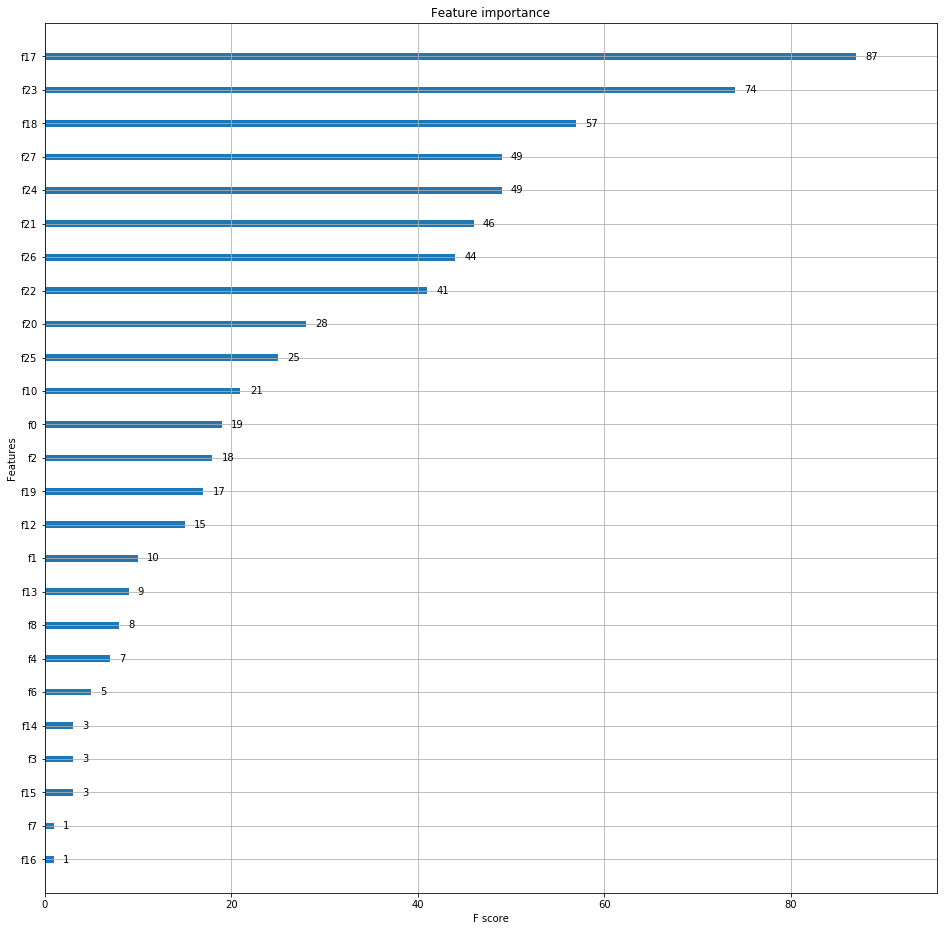

In [768]:
my_plot_importance(win_model,(16,16))

In [752]:
print(target_data.columns[23])

mktcap


In [749]:
print(np.where(loss_predict[target_column] <= 0)[0].shape)
print(np.where(win_predict[target_column] > 0)[0].shape)
losses = loss_model.predict(loss_x)
print(max(losses))
print(np.where(losses > 0)[0].shape)

(1971,)
(1091,)
-0.0010251999
(0,)


In [763]:
print(wins_for_losses.shape)
print(losses_for_wins.shape)
print(max(wins_for_losses),min(wins_for_losses))
print(max(losses_for_wins),min(losses_for_wins))
print(np.where(losses_for_wins > 0)[0].shape)
print(np.where(wins_for_losses <= 0)[0].shape)
print(wins_for_losses[:5])
print(losses_for_wins[:5])
assert wins_for_losses.shape[0] + losses_for_wins.shape[0] == trades.shape[0]

(1971,)
(1091,)
4.675333 -0.21455908
-0.03019613 -11.172142
(0,)
(5,)
[0.12352732 0.10702813 1.2416155  0.52992916 0.12172824]
[-0.0698241  -0.0698241  -0.3124637  -0.20370704 -0.8222586 ]


In [759]:
print(max(trades['percent_gain']))
print(min(trades['percent_gain']))
trades.head(5)

0.756268656716418
-0.7901041666666666


,idsym,opendt,symbol,quantity,is_long,closedt,realized,open_fill_id,close_fill_id,average_entry_price,...,ultra,lev,is_lev,use?,per_share_return,atr14_percent,atr14_lag_percent,percent_gain,trade_duration,held_overnight
0,22072,2017-11-30T14:52:51.000Z,FB,1500.0,0,2017-11-30T14:56:06.000Z,-140.76,148050598,148050624,175.708667,...,0,0,0,1.0,-0.093840,0.013982,0.013707,-0.000534,195.0,0
1,22072,2017-11-30T14:39:23.000Z,FB,2250.0,0,2017-11-30T14:42:08.000Z,-1198.50,148050567,148050582,175.534667,...,0,0,0,1.0,-0.532667,0.013982,0.013707,-0.003035,165.0,0
2,22072,2017-11-30T14:44:13.000Z,FB,750.0,0,2017-11-30T14:48:49.000Z,202.01,148050542,148050566,176.549347,...,0,0,0,1.0,0.269347,0.013982,0.013707,0.001526,276.0,0
3,22072,2017-11-30T15:39:58.000Z,FB,2500.0,0,2017-11-30T16:54:37.000Z,1614.06,148050551,148050653,177.772800,...,0,0,0,1.0,0.645624,0.013982,0.013707,0.003632,4479.0,0
4,2475,2017-11-30T14:19:07.000Z,KR,1000.0,1,2018-01-08T17:31:25.000Z,0.28,148050668,149232030,27.673940,...,0,0,0,1.0,0.000280,0.032441,0.024061,0.000010,3381138.0,1


In [755]:
#Need to reuse the scaler and categories

projected_stops = []
win_index = 0
loss_index = 0
for index, row in trades.iterrows():
    #Check if trade was win or not
    percent_gain = row[-3]
    if percent_gain <= 0:
        # add win to the loss
        projected_stops.append(wins_for_losses[loss_index])
        loss_index += 1
    else:
        # add loss to the win
        if win_index == 1091:
            print(index)
        projected_stops.append(losses_for_wins[win_index])
        win_index += 1
#     projected_stops.append(projected_stop)
    
# create new feature for trades
print(len(projected_stops))
# trades['projected_stop'] = projected_stops

2874


IndexError: index 1091 is out of bounds for axis 0 with size 1091

In [80]:
print(target_data.shape)
print(win_predict.shape)
print(loss_predict.shape)
print(losses_for_wins)
print(wins_for_losses)

(1884, 30)
(729, 30)
(1155, 30)
[-0.00279951 -0.00343239 -0.02278948 -0.01429331 -0.03184217 -0.01265842
 -0.00759494 -0.00377703 -0.00837505 -0.00969636 -0.00312096 -0.02095681
 -0.0098471  -0.04242969 -0.00500816 -0.01037407 -0.00852132 -0.03892207
 -0.03141868 -0.11116242 -0.06051332 -0.02999622 -0.01722324 -0.00377703
 -0.02689707 -0.00485235 -0.08038783 -0.02492809 -0.00610048 -0.00573224
 -0.00279951 -0.00369614 -0.05703205 -0.01407564 -0.00469971 -0.00469971
 -0.00389653 -0.00796068 -0.05554283 -0.00806075 -0.00863028 -0.00863028
 -0.0054453  -0.01883644 -0.00715977 -0.00802952 -0.00627488 -0.00641072
 -0.00597078 -0.00835651 -0.00703418 -0.00423944 -0.01364535 -0.07445937
 -0.00529015 -0.00245273 -0.00273949 -0.0181976  -0.0112319  -0.00330794
 -0.00375253 -0.00405276 -0.00670791 -0.00701511 -0.02022469 -0.02151042
 -0.00826061 -0.00312078 -0.00436479 -0.00449055 -0.0242846  -0.01079053
 -0.00827104 -0.0069229  -0.0062961  -0.0051192  -0.00298679 -0.01252848
 -0.01491386 -0.004